# MNIST Classifier Using PCA and Hyperparameter Tuning and Ensemble learning

## Importing necessary libraries

In [96]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from xgboost import XGBClassifier
import warnings

## Load the MNIST Dataset

We will first load the MNIST dataset and perform some preprocessing steps, including feature selection based on correlation with the target label. Additionally, we will sample the dataset to speed up the computations.

In [40]:
mnist_train = pd.read_csv("mnist_train.csv")
mnist_test = pd.read_csv("mnist_test.csv")

mnist_train = mnist_train.sample(n=20000, random_state=42)

threshold = 0.02
correlations = mnist_train.corr()
target_correlations = correlations['label'].abs()
to_keep = target_correlations[target_correlations > threshold].index

mnist_train_ = mnist_train.loc[:, to_keep]
mnist_test_ = mnist_test.loc[:, to_keep]

reduced_features = mnist_train_.shape[1] - 1

print(f"Original number of features: {mnist_train.shape[1] - 1}")
print(f"Reduced number of features: {mnist_train_.shape[1] - 1}")

X_train = mnist_train_.drop(columns=['label']).values
y_train = mnist_train_['label'].values
X_test = mnist_test_.drop(columns=['label']).values
y_test = mnist_test_['label'].values

X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

Original number of features: 784
Reduced number of features: 517


## Apply PCA for Dimensionality Reduction

Defining a function to apply PCA to the dataset with varying numbers of components and calculate the reconstruction loss.

In [15]:
warnings.filterwarnings("ignore") # To ignore all warnings

def apply_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    # Calculate reconstruction loss
    X_train_reconstructed = pca.inverse_transform(X_train_pca)
    reconstruction_loss = np.mean((X_train - X_train_reconstructed) ** 2)
    return X_train_pca, X_test_pca, reconstruction_loss

## Define Models and Hyperparameter Tuning

Defining multiple classification models and set up hyperparameter tuning for some of them using RandomizedSearchCV. 
We'll also define a function for training and evaluating each model.

In [85]:
pca_components = [10, 20, 30, 40]
pca_components.extend(range(50, reduced_features, 50))

models = {
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}  # No hyperparameters for tuning
    },
    'k-NN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1, 3, 5, 7, 9],  # Odd values for better result
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [None, 10, 20, 30, 40],
            'min_samples_split': [2, 5, 10, 15, 20],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [None, 10, 20, 30, 40],
            'max_features': ['log2', 'sqrt', None]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2', 'l1'],
            'solver': ['liblinear', 'saga']
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.01, 0.1, 1],
            'kernel': ['rbf', 'poly'], # Using only these two because the other two are guarenteed to get less acc that these two kernels
            'degree': [2, 3, 4]  # Only relevant for `poly` kernel
        }
    }
}


In [17]:
def train_and_evaluate(model_name, model_info, X_train_pca, y_train, X_test_pca, y_test):
    print(f"Training {model_name}...")
    model = model_info['model']
    param_grid = model_info['params']

    random_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
    random_search.fit(X_train_pca, y_train)

    best_params = random_search.best_params_
    best_model = random_search.best_estimator_

    start_time = time.time()
    best_model.fit(X_train_pca, y_train)
    training_time = time.time() - start_time

    accuracy = accuracy_score(y_test, best_model.predict(X_test_pca))

    ovr = OneVsRestClassifier(random_search.best_estimator_)
    ovr.fit(X_train_pca, y_train)
    acc_ovr = accuracy_score(y_test, ovr.predict(X_test_pca))

    ovo = OneVsOneClassifier(random_search.best_estimator_)
    ovo.fit(X_train_pca, y_train)
    acc_ovo = accuracy_score(y_test, ovo.predict(X_test_pca))
    
    error_rates_per_digit = {}
    for digit in range(10):
        total_count = np.sum(y_test == digit)
        misclassified_count = np.sum((best_model.predict(X_test_pca) != y_test) & (y_test == digit))
        error_rate = misclassified_count / total_count if total_count > 0 else np.nan
        error_rates_per_digit[digit] = error_rate
    
    return {
        'model_name': model_name,
        'best_params': best_params,
        'accuracy': accuracy,
        'training_time': training_time,
        'error_rates_per_digit': error_rates_per_digit,
        'acc_ovr': acc_ovr,
        'acc_ovo': acc_ovo
    }

## Model Evaluation for Different PCA Components

We will now run the models with varying PCA components, gather the results, and track accuracy, error rates, and reconstruction loss.

In [18]:
overall_best_params = {name: None for name in models.keys()}
overall_best_accuracy = {name: 0 for name in models.keys()}
overall_best_components = {name: None for name in models.keys()}

results = []
reconstruction_losses = []
model_accuracies_random = {name: [] for name in models.keys()}
model_accuracies_ovo = {name: [] for name in models.keys()}
model_accuracies_ovr = {name: [] for name in models.keys()}

error_rates_per_digit_all = {model_name: {digit: [] for digit in range(10)} for model_name in models.keys()}

pca_components = [10, 20, 30, 40]
pca_components.extend(range(50, reduced_features, 50))

for n_components in pca_components:
    print(f"\n--- PCA with {n_components} components ---")
    X_train_pca, X_test_pca, reconstruction_loss = apply_pca(X_train_scaled, X_test_scaled, n_components)
    reconstruction_losses.append(reconstruction_loss)
    print(f"Reconstruction Loss: {reconstruction_loss:.4f}")
    
    model_results = []
    for model_name, model_info in models.items():
        model_result = train_and_evaluate(model_name, model_info, X_train_pca, y_train, X_test_pca, y_test)
        model_results.append(model_result)
    
    for model_result in model_results:
        model_name = model_result['model_name']
        model_accuracies_random[model_name].append(model_result['accuracy'])
        model_accuracies_ovo[model_name].append(model_result['acc_ovo'])
        model_accuracies_ovr[model_name].append(model_result['acc_ovr'])
        
        if model_result['accuracy'] > overall_best_accuracy[model_name]:
            overall_best_accuracy[model_name] = model_result['accuracy']
            overall_best_params[model_name] = model_result['best_params']
            overall_best_components[model_name] = n_components
            
        for digit, error_rate in model_result['error_rates_per_digit'].items():
            error_rates_per_digit_all[model_name][digit].append(error_rate)
            
    results.append({
        'components': n_components,
        'models': model_results
    })

    print(f"\nResults for PCA Components = {n_components}")
    for model_result in model_results:
        print(f"{model_result['model_name']} - Accuracy: {model_result['accuracy']:.4f}, "
              f"Training Time: {model_result['training_time']:.2f}s, "
              f"Best Params: {model_result['best_params']}")


--- PCA with 10 components ---
Reconstruction Loss: 0.0472
Training Naive Bayes...
Training k-NN...
Training Decision Tree...
Training Random Forest...
Training Logistic Regression...
Training SVM...

Results for PCA Components = 10
Naive Bayes - Accuracy: 0.7758, Training Time: 0.01s, Best Params: {}
k-NN - Accuracy: 0.9166, Training Time: 0.02s, Best Params: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'euclidean'}
Decision Tree - Accuracy: 0.7936, Training Time: 0.27s, Best Params: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None}
Random Forest - Accuracy: 0.8945, Training Time: 9.22s, Best Params: {'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 40}
Logistic Regression - Accuracy: 0.8051, Training Time: 0.37s, Best Params: {'solver': 'saga', 'penalty': 'l2', 'C': 10}
SVM - Accuracy: 0.9323, Training Time: 3.06s, Best Params: {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1}

--- PCA with 20 components ---
Reconstruction Loss: 0.0329
Training Na

## Overall Best Parameters for each model

In [19]:
print("\n--- Overall Best Parameters and Accuracy for Each Model ---\n")
for model_name in models.keys():
    print(f"{model_name} - Best Accuracy: {overall_best_accuracy[model_name]:.4f}, "
          f"Best Params: {overall_best_params[model_name]}, "
          f"Best PCA Components: {overall_best_components[model_name]}")



--- Overall Best Parameters and Accuracy for Each Model ---

Naive Bayes - Best Accuracy: 0.8801, Best Params: {}, Best PCA Components: 50
k-NN - Best Accuracy: 0.9659, Best Params: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'minkowski'}, Best PCA Components: 50
Decision Tree - Best Accuracy: 0.8120, Best Params: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None}, Best PCA Components: 40
Random Forest - Best Accuracy: 0.9441, Best Params: {'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 40}, Best PCA Components: 40
Logistic Regression - Best Accuracy: 0.9201, Best Params: {'solver': 'saga', 'penalty': 'l2', 'C': 0.1}, Best PCA Components: 500
SVM - Best Accuracy: 0.9743, Best Params: {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1}, Best PCA Components: 30


## Plot reconstruction loss vs PCA components


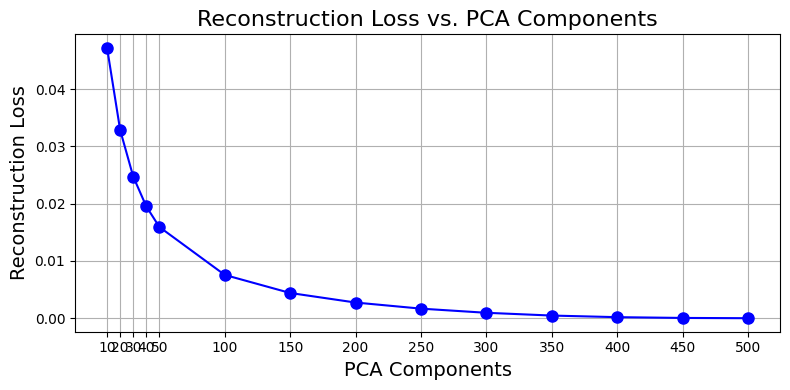

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(pca_components, reconstruction_losses, marker='o', color='b', linestyle='-', markersize=8)
plt.xlabel('PCA Components', fontsize=14)
plt.ylabel('Reconstruction Loss', fontsize=14)
plt.title('Reconstruction Loss vs. PCA Components', fontsize=16)
plt.xticks(pca_components)
plt.grid(True)
plt.tight_layout()
plt.show()


## Plot for Accuracy Comparison for Different Models vs. PCA Components

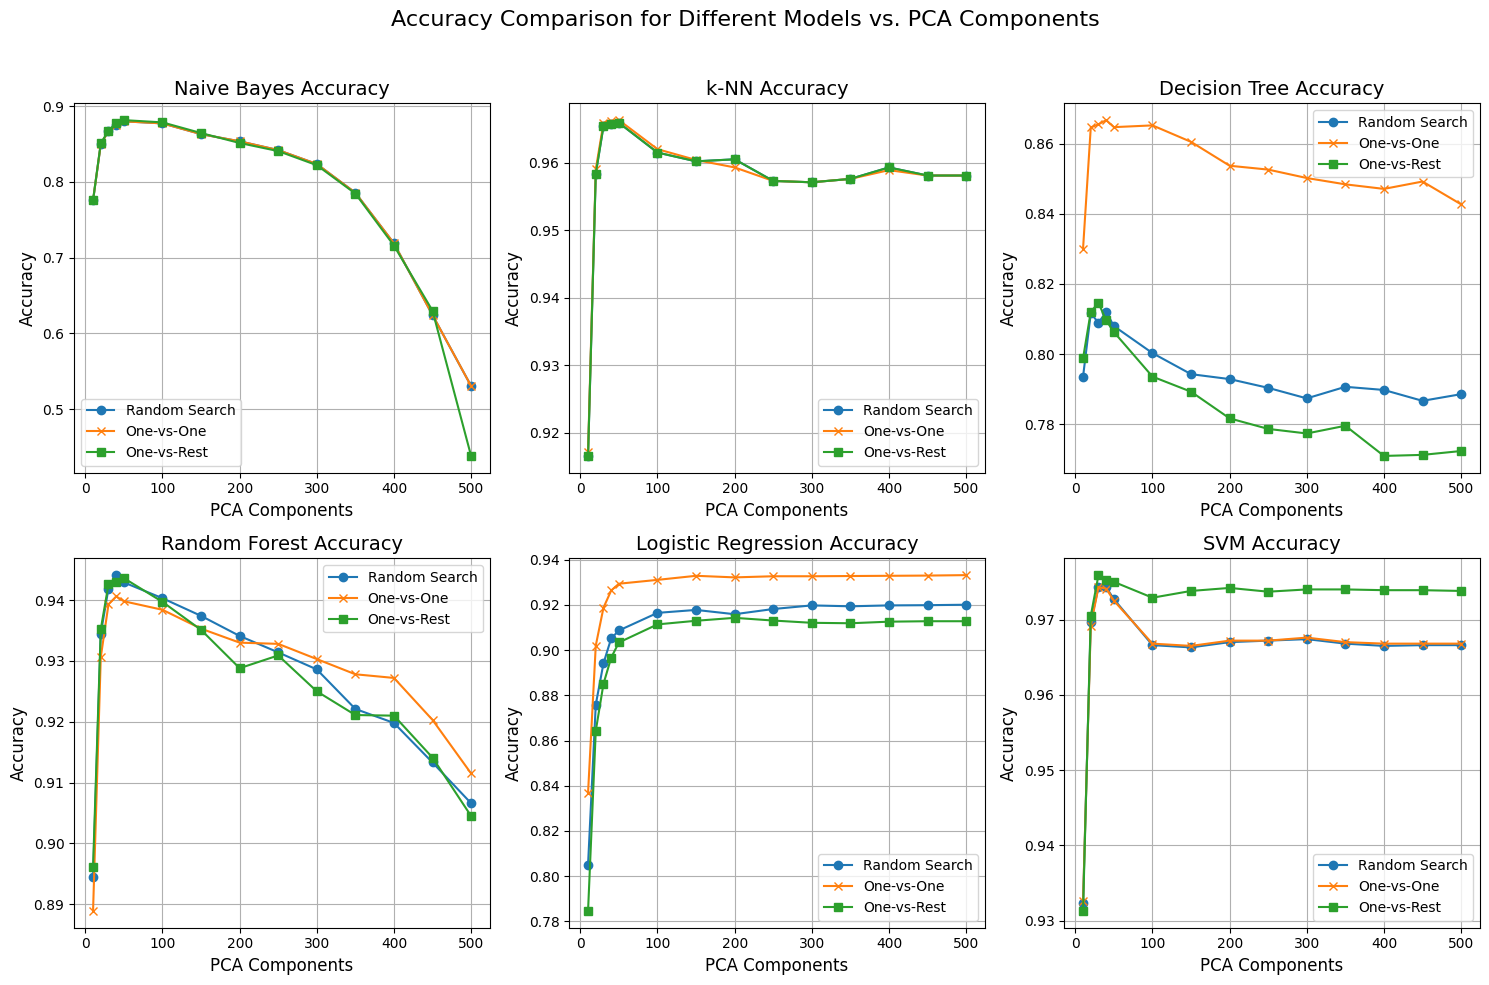

In [21]:

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()  # Flatten for easier indexing

fig.suptitle('Accuracy Comparison for Different Models vs. PCA Components', fontsize=16)

for idx, model_name in enumerate(models.keys()):
    ax = axes[idx]
    ax.plot(pca_components, model_accuracies_random[model_name], label=f"Random Search", marker='o')
    ax.plot(pca_components, model_accuracies_ovo[model_name], label=f"One-vs-One", marker='x')
    ax.plot(pca_components, model_accuracies_ovr[model_name], label=f"One-vs-Rest", marker='s')

    ax.set_xlabel('PCA Components', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f'{model_name} Accuracy', fontsize=14)
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the main title
plt.show()


## Plot for Error Rate per Digit for Different Models vs. PCA Components

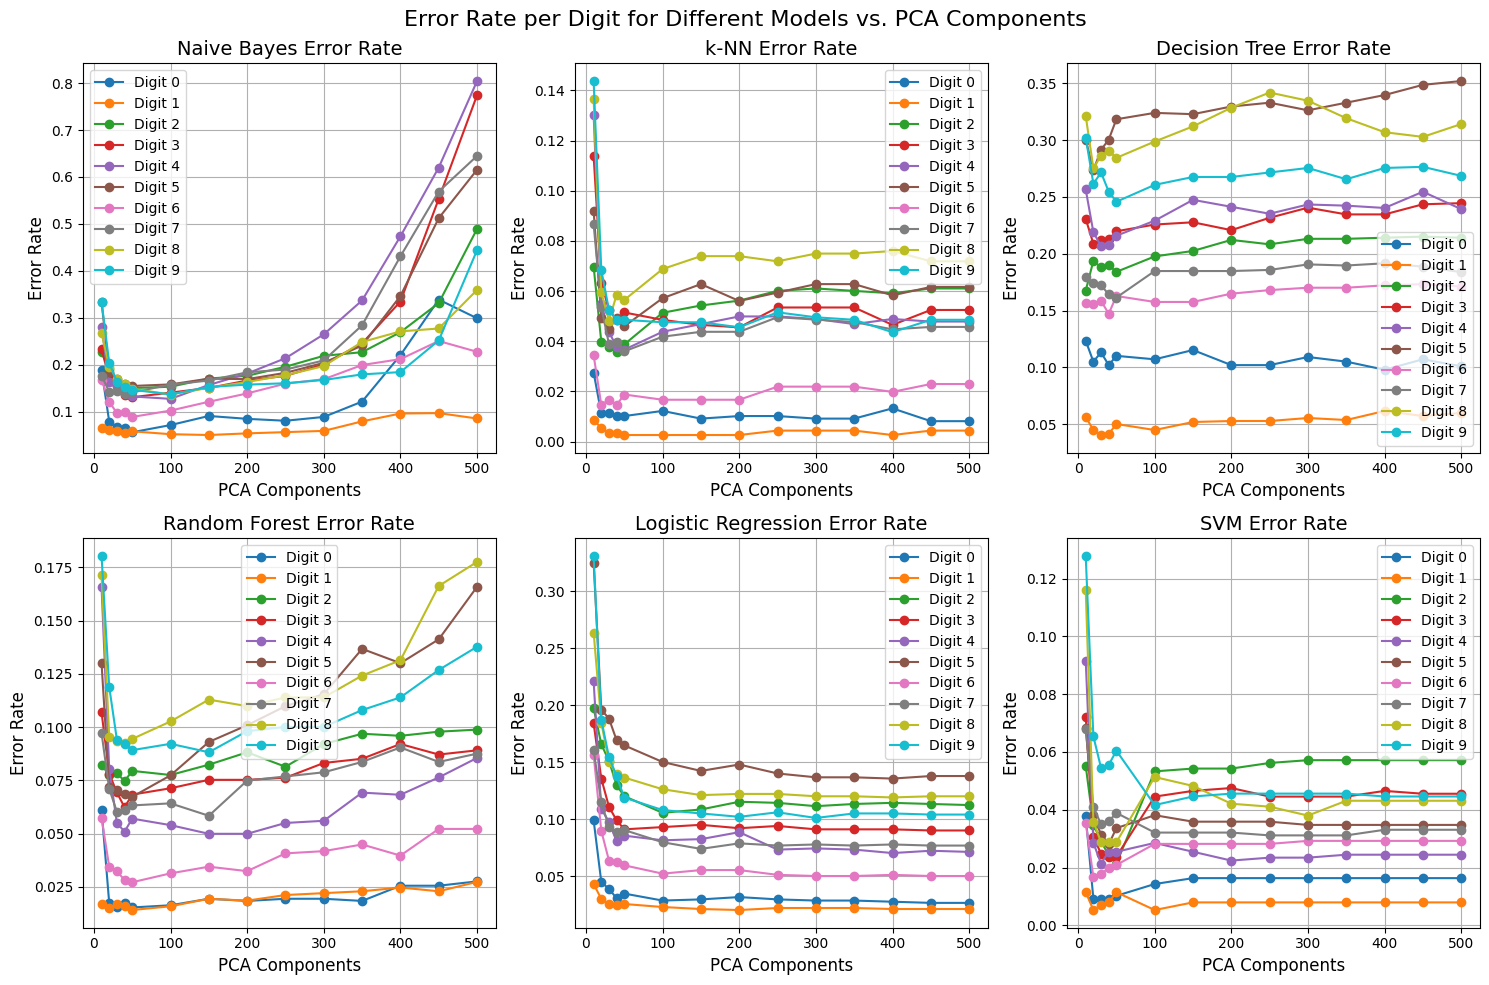

In [22]:

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Main title for the whole error rate plot
fig.suptitle('Error Rate per Digit for Different Models vs. PCA Components', fontsize=16)

for idx, (model_name, error_rates) in enumerate(error_rates_per_digit_all.items()):
    ax = axes[idx]
    for digit in range(10):
        errors = error_rates[digit]
        ax.plot(pca_components, errors, marker='o', label=f'Digit {digit}')

    ax.set_xlabel('PCA Components', fontsize=12)
    ax.set_ylabel('Error Rate', fontsize=12)
    ax.set_title(f'{model_name} Error Rate', fontsize=14)
    ax.legend()
    ax.grid(True)

plt.tight_layout() 
plt.show()


## Saving the results

In [23]:

flat_results = []

for result in results:
    n_components = result['components']
    for model_result in result['models']:
        flat_results.append({
            'PCA_Components': n_components,
            'Model': model_result['model_name'],
            'Accuracy': model_result['accuracy'],
            'Training_Time': model_result['training_time'],
            'Best_Parameters': model_result['best_params'],
            'Error_Rates_Per_Digit': model_result['error_rates_per_digit'],
            'Acc_OVR': model_result['acc_ovr'],
            'Acc_OVO': model_result['acc_ovo']
        })

df = pd.DataFrame(flat_results)

df.to_csv("mnist_classifier_results.csv", index=False)

print("Results Saved Succesfully")


Results Saved Succesfully


## Classification reports for the Best Models

In [72]:
def plot_classification_report_and_confusion_matrix(y_true, y_pred, title, time):
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    conf_matrix = confusion_matrix(y_true, y_pred)

    accuracy = accuracy_score(y_true, y_pred)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1, 0.5]})

    fig.suptitle(title, fontsize=24, fontweight='bold')

    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted Labels")
    axes[0].set_ylabel("True Labels")

    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="YlGn", ax=axes[1], cbar=True)
    axes[1].set_title("Classification Report")
    axes[1].set_yticklabels(report_df.index[:-1], rotation=0)
    axes[1].set_xticklabels(report_df.columns[:-1])

    axes[2].text(0.5, 0.8, f"Overall Accuracy: {accuracy:.2%}", fontsize=20, ha="center")    
    axes[2].text(0.5, 0.6, f"Training Time: {time:.2f} seconds", fontsize=17, ha="center")
    axes[2].text(0.5, 0.5, f"Macro Avg Precision: {report['macro avg']['precision']:.2f}", fontsize=17, ha="center")
    axes[2].text(0.5, 0.4, f"Macro Avg Recall: {report['macro avg']['recall']:.2f}", fontsize=17, ha="center")
    axes[2].text(0.5, 0.3, f"Weighted Avg Precision: {report['weighted avg']['precision']:.2f}", fontsize=17, ha="center")
    axes[2].text(0.5, 0.2, f"Weighted Avg Recall: {report['weighted avg']['recall']:.2f}", fontsize=17, ha="center")
    axes[2].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [73]:
def report(model_name, model, X_train_scaled, y_train, X_test, y_test, components):
    X_train_pca, X_test_pca, reconstruction_loss = apply_pca(X_train_scaled, X_test_scaled, components)
    start = time.time()
    model.fit(X_train_pca, y_train)
    plot_classification_report_and_confusion_matrix(y_test, model.predict(X_test_pca), f"Report for {model_name}", time.time() - start)

    start = time.time()
    ovo_model = OneVsOneClassifier(model)
    ovo_model.fit(X_train_pca, y_train)
    plot_classification_report_and_confusion_matrix(y_test, ovo_model.predict(X_test_pca), f"Report for {model_name}-OvO", time.time() - start)

    start = time.time()
    ovr_model = OneVsRestClassifier(model)
    ovr_model.fit(X_train_pca, y_train)
    plot_classification_report_and_confusion_matrix(y_test, ovr_model.predict(X_test_pca), f"Report for {model_name}-OvR", time.time() - start)


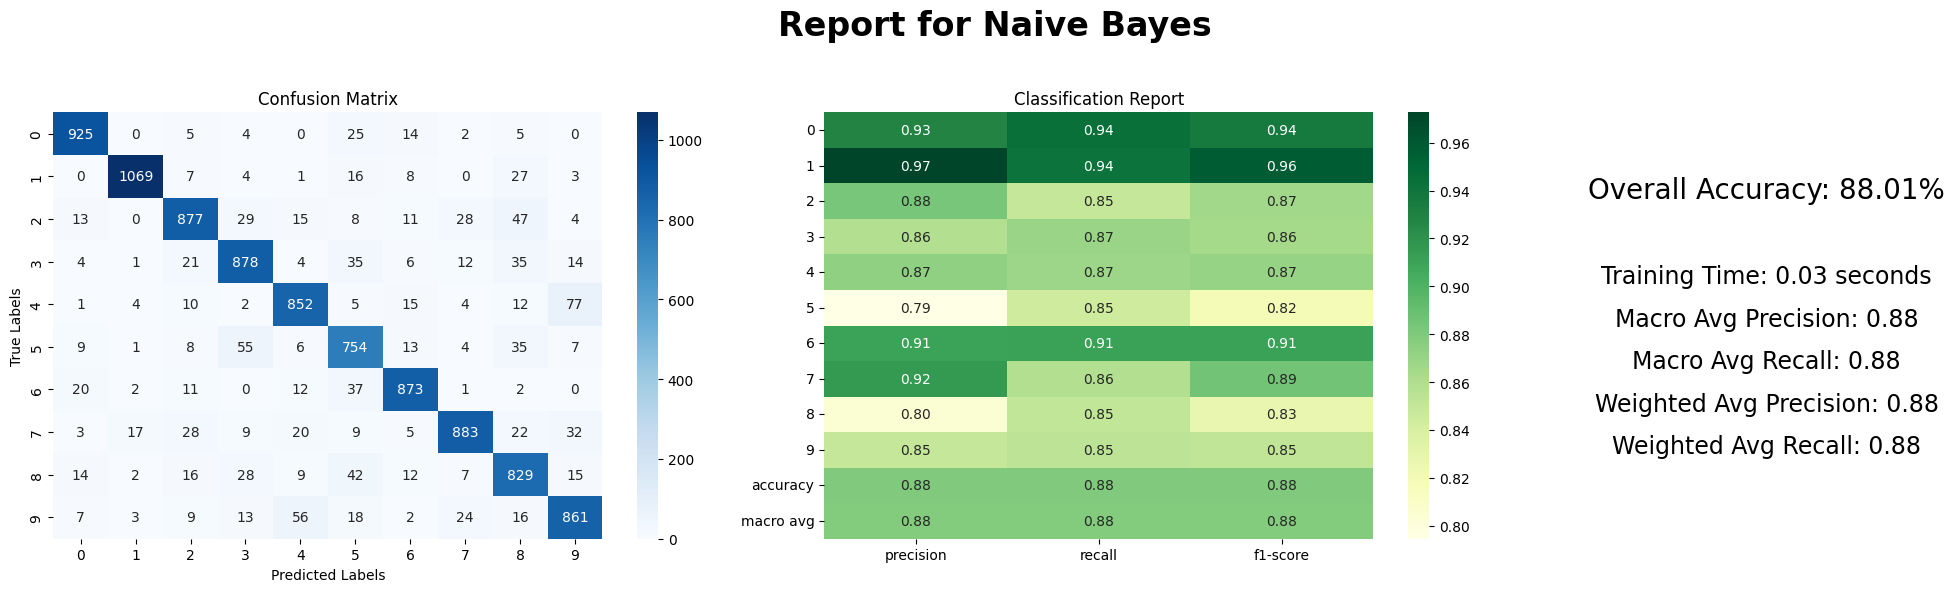

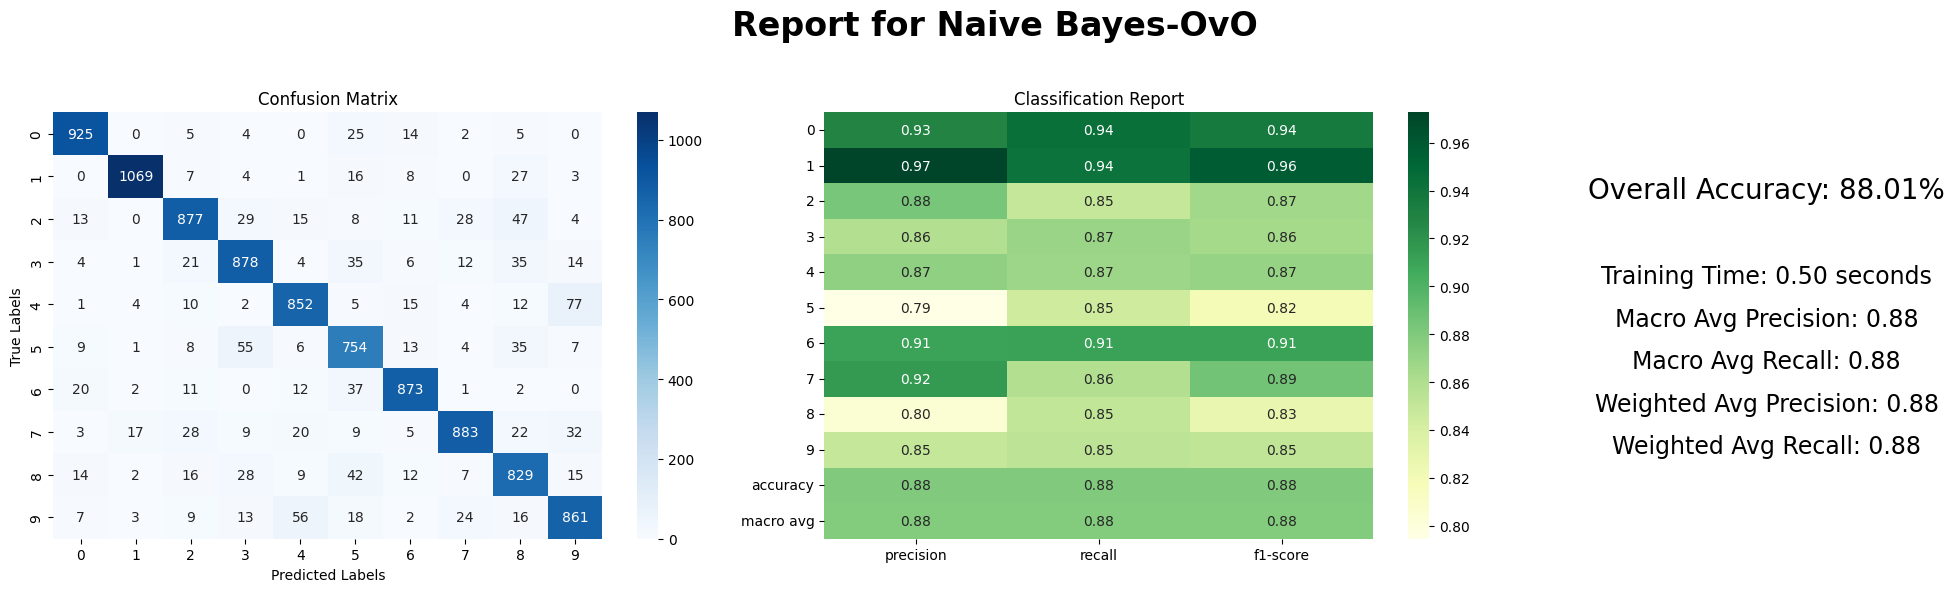

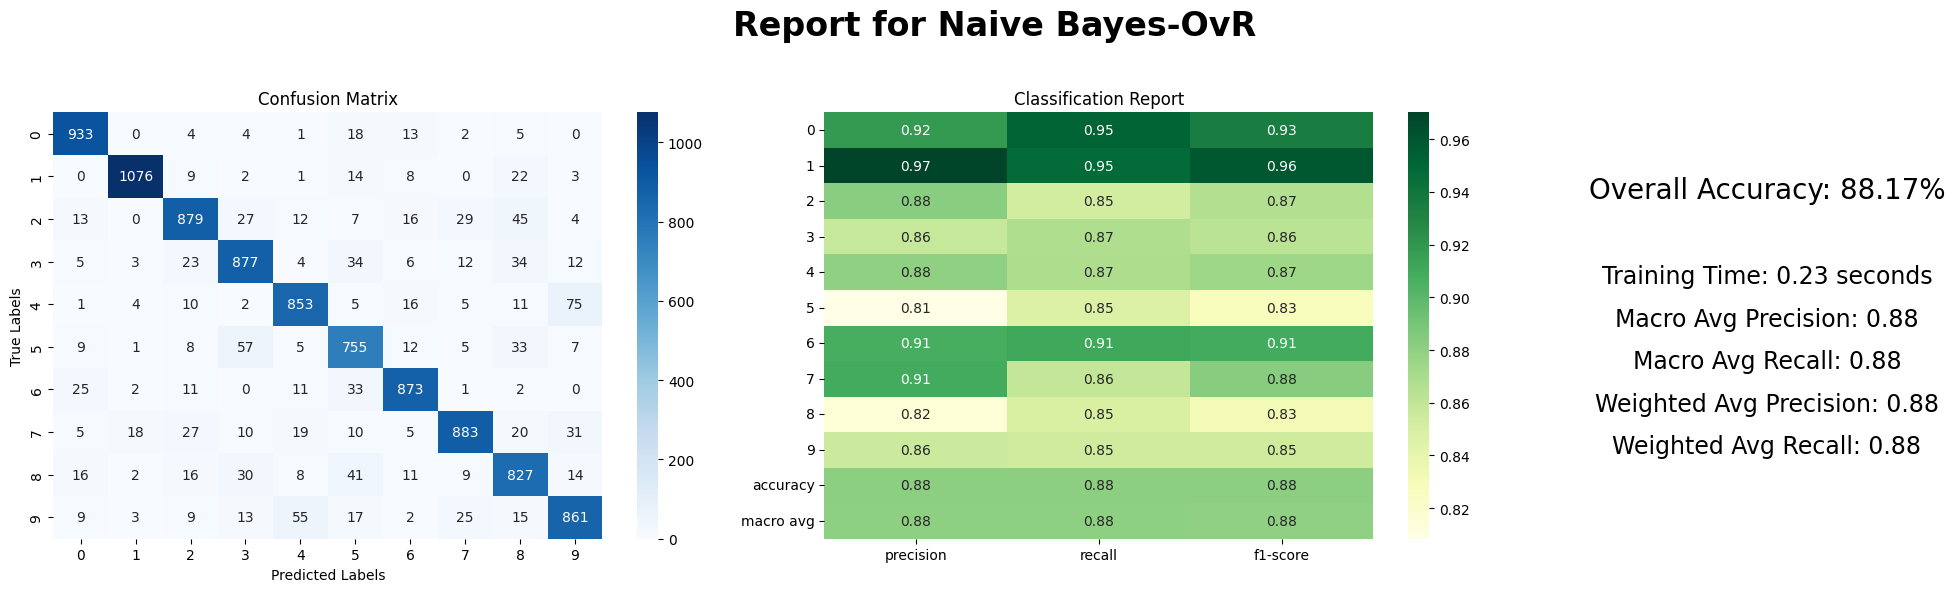

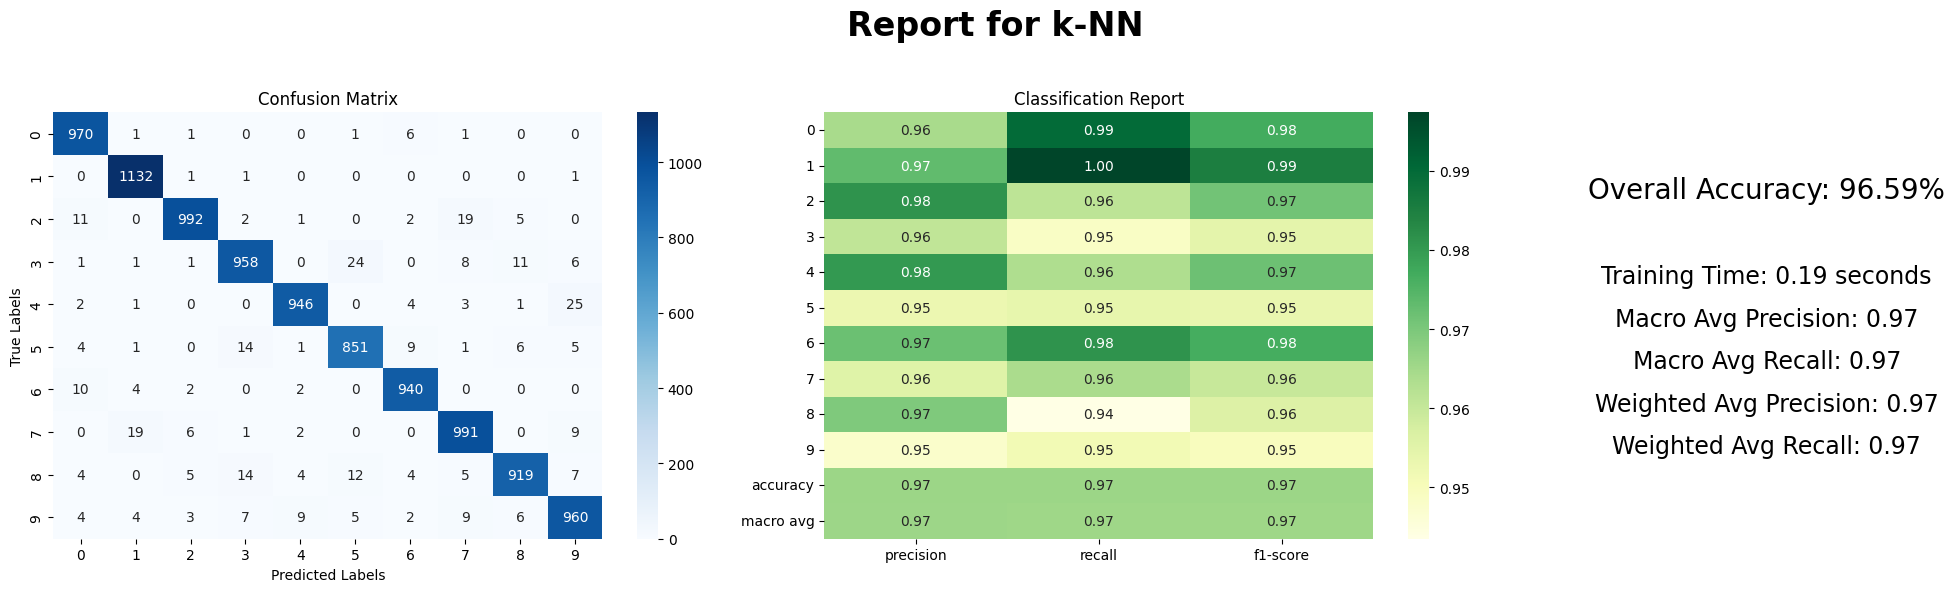

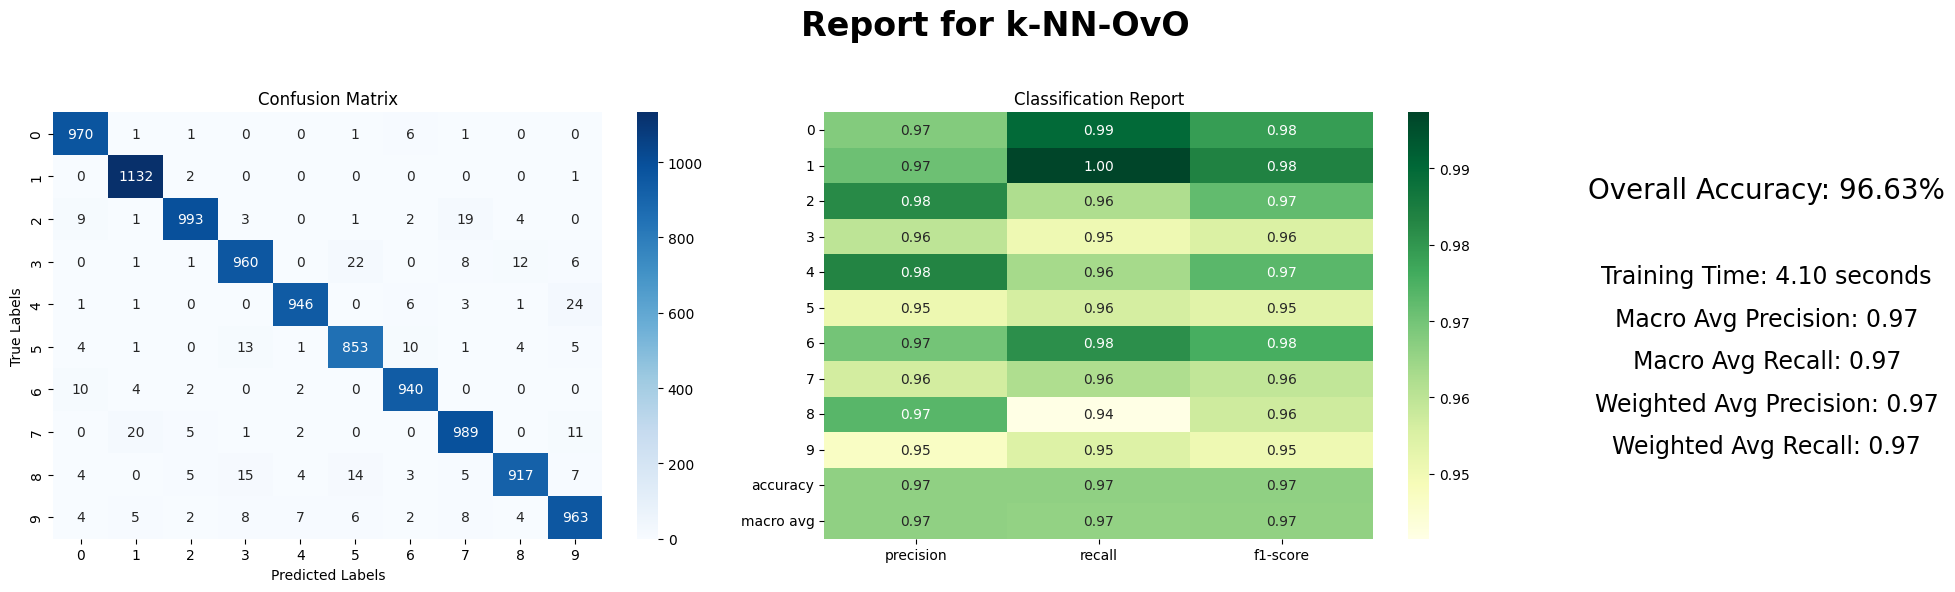

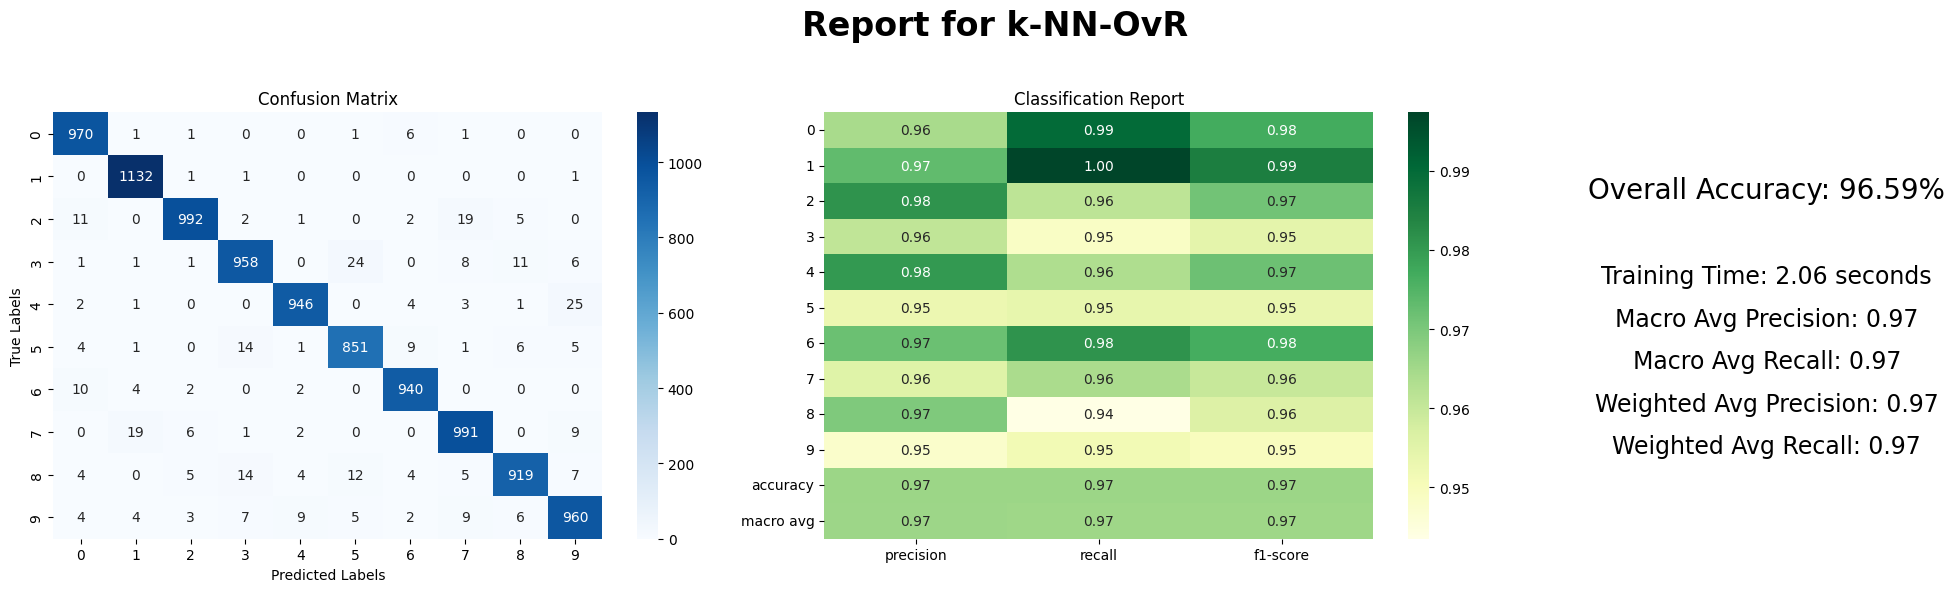

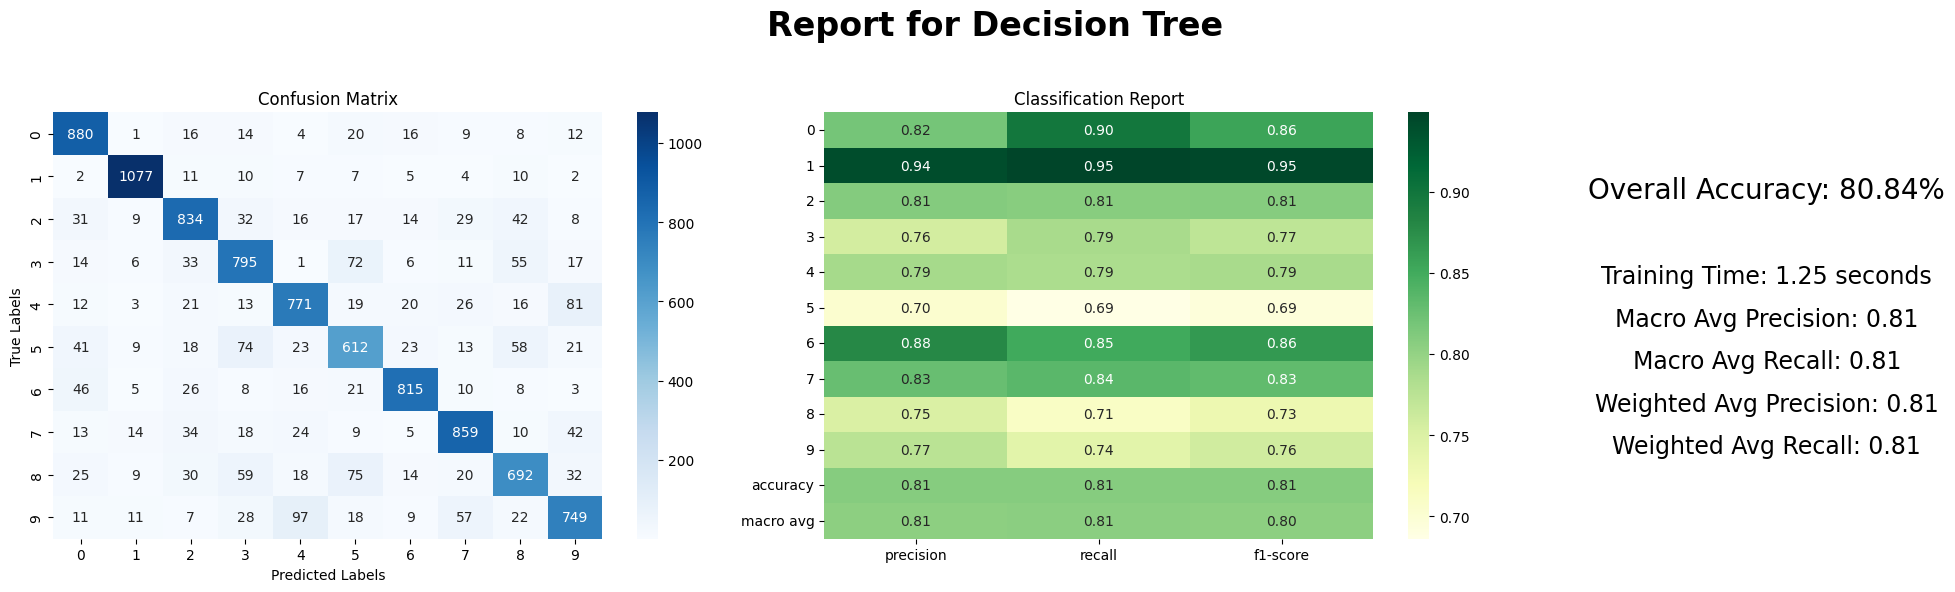

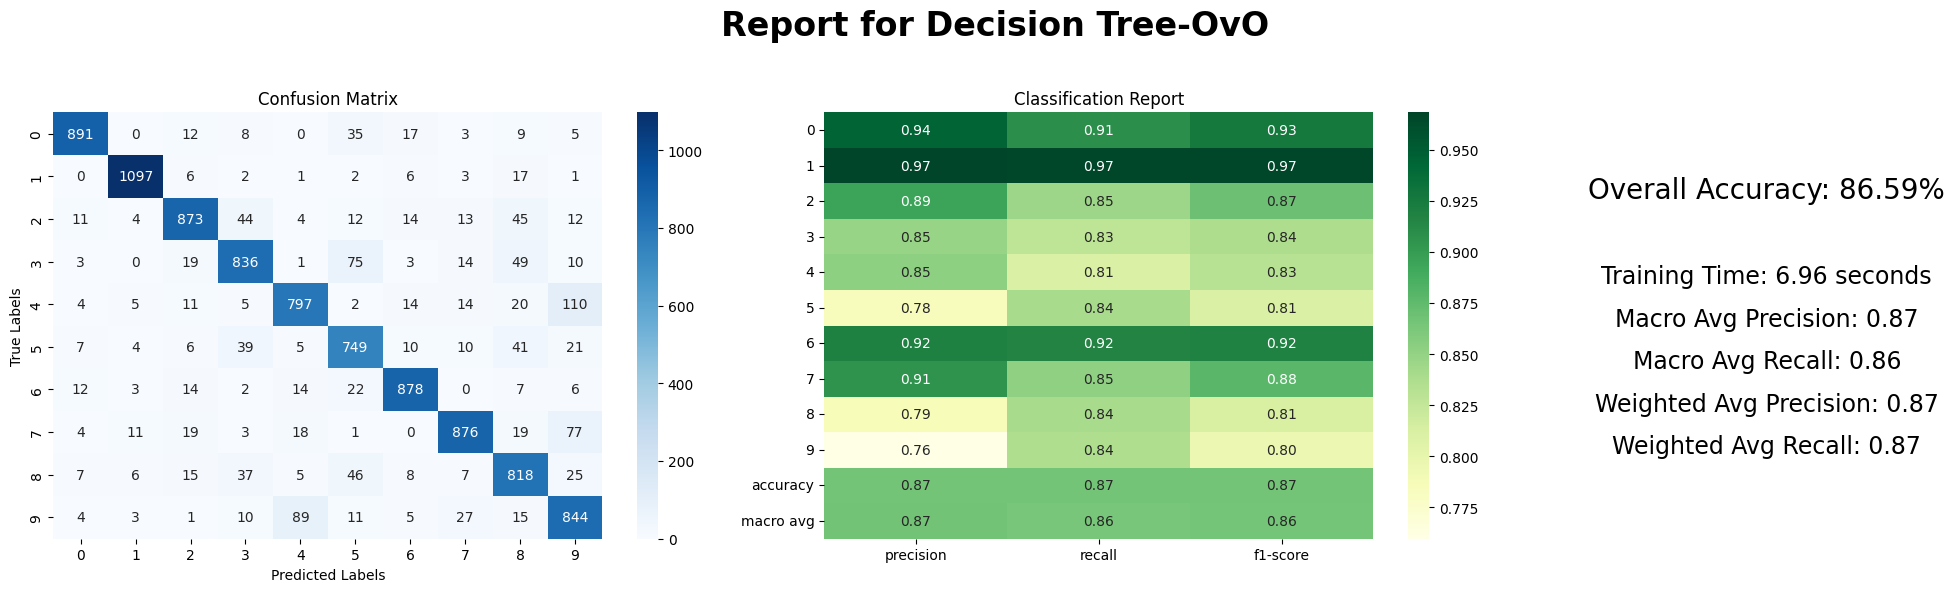

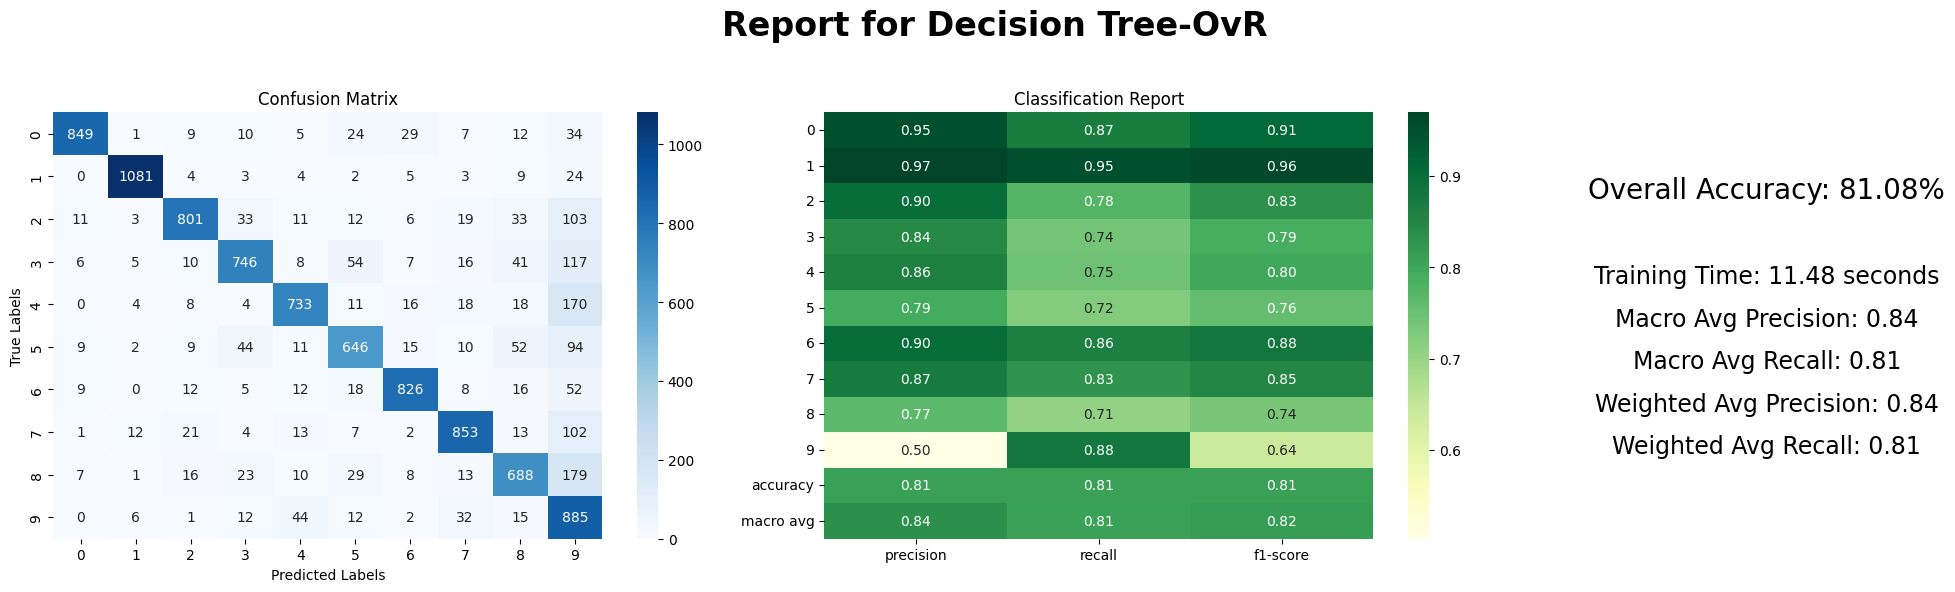

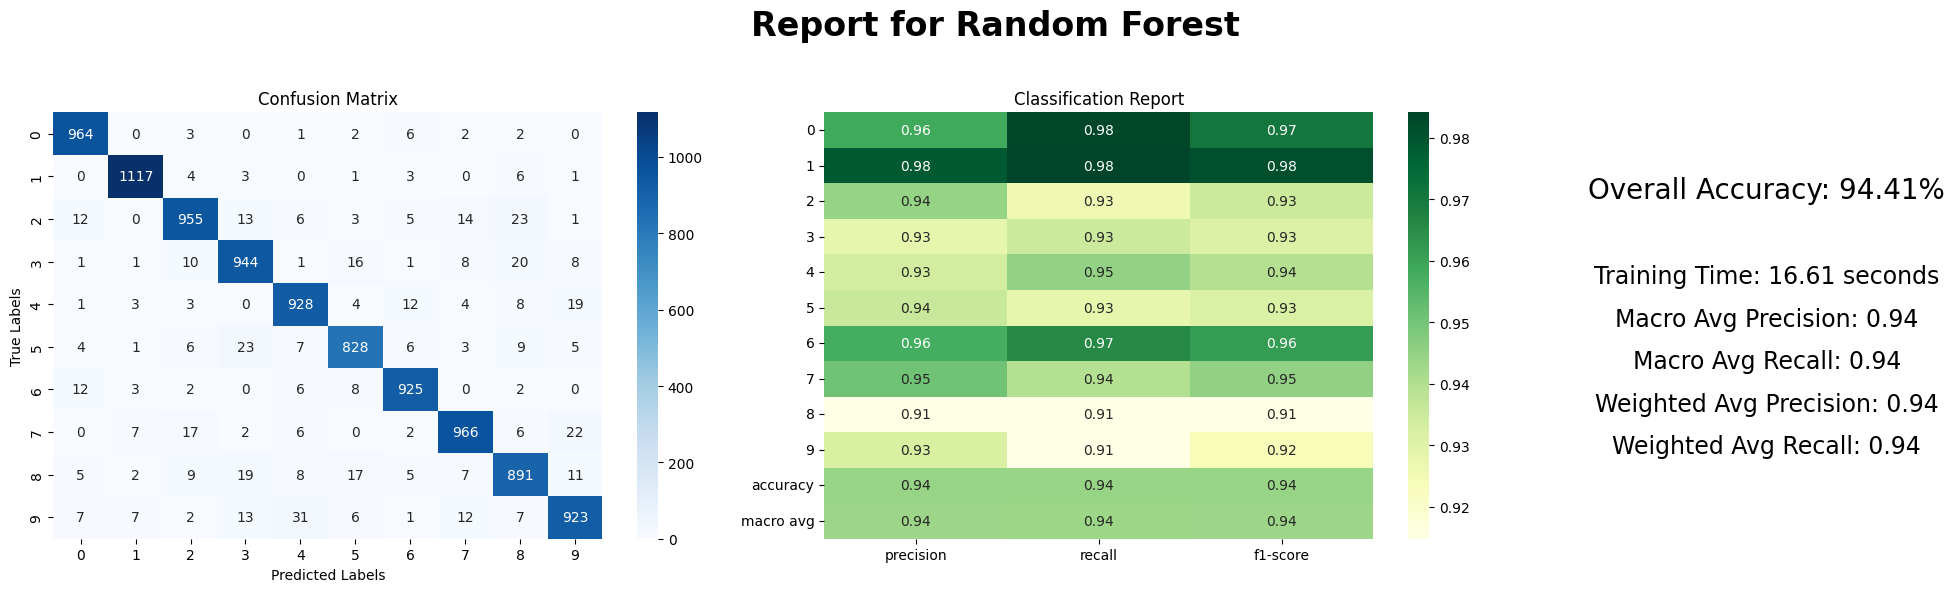

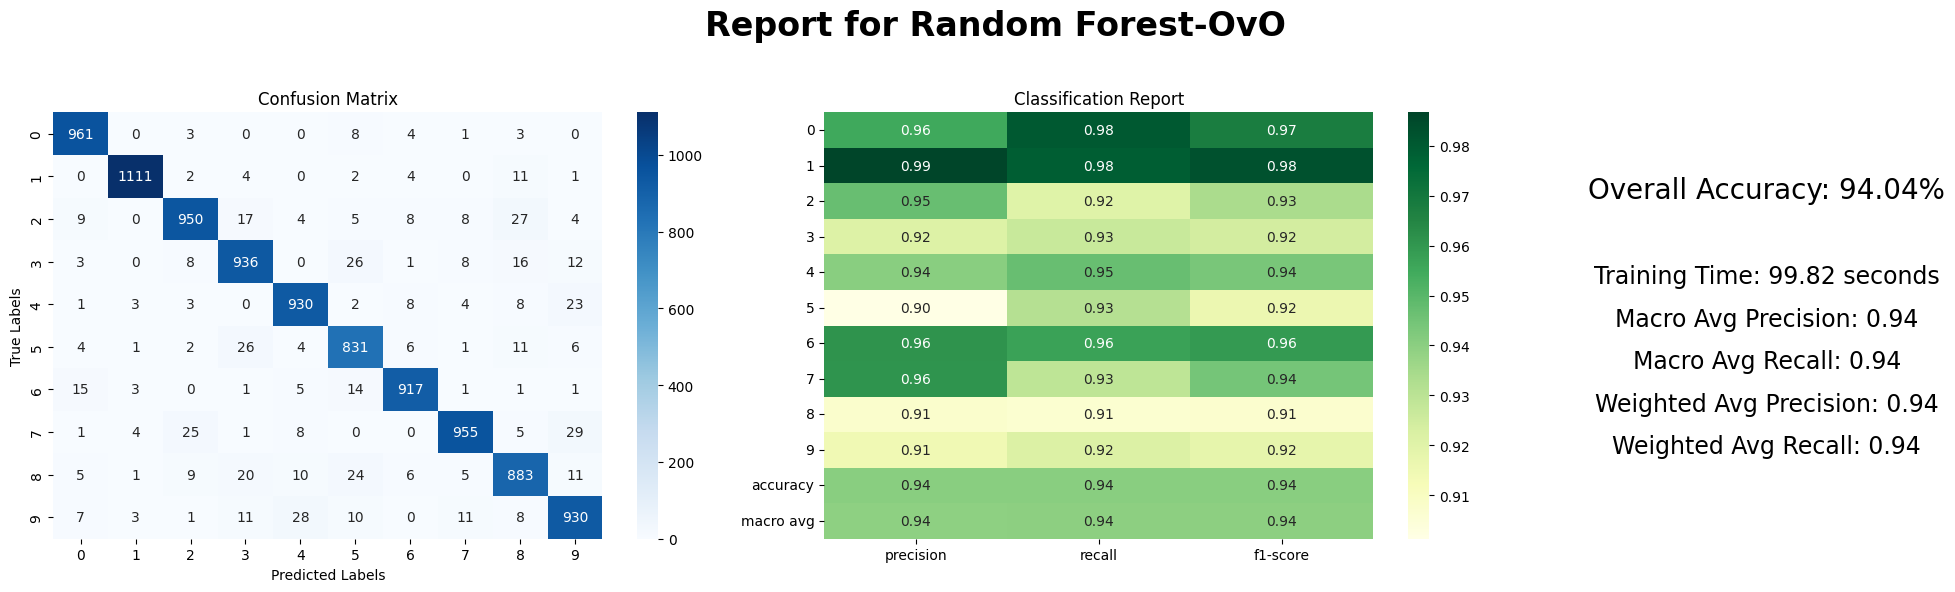

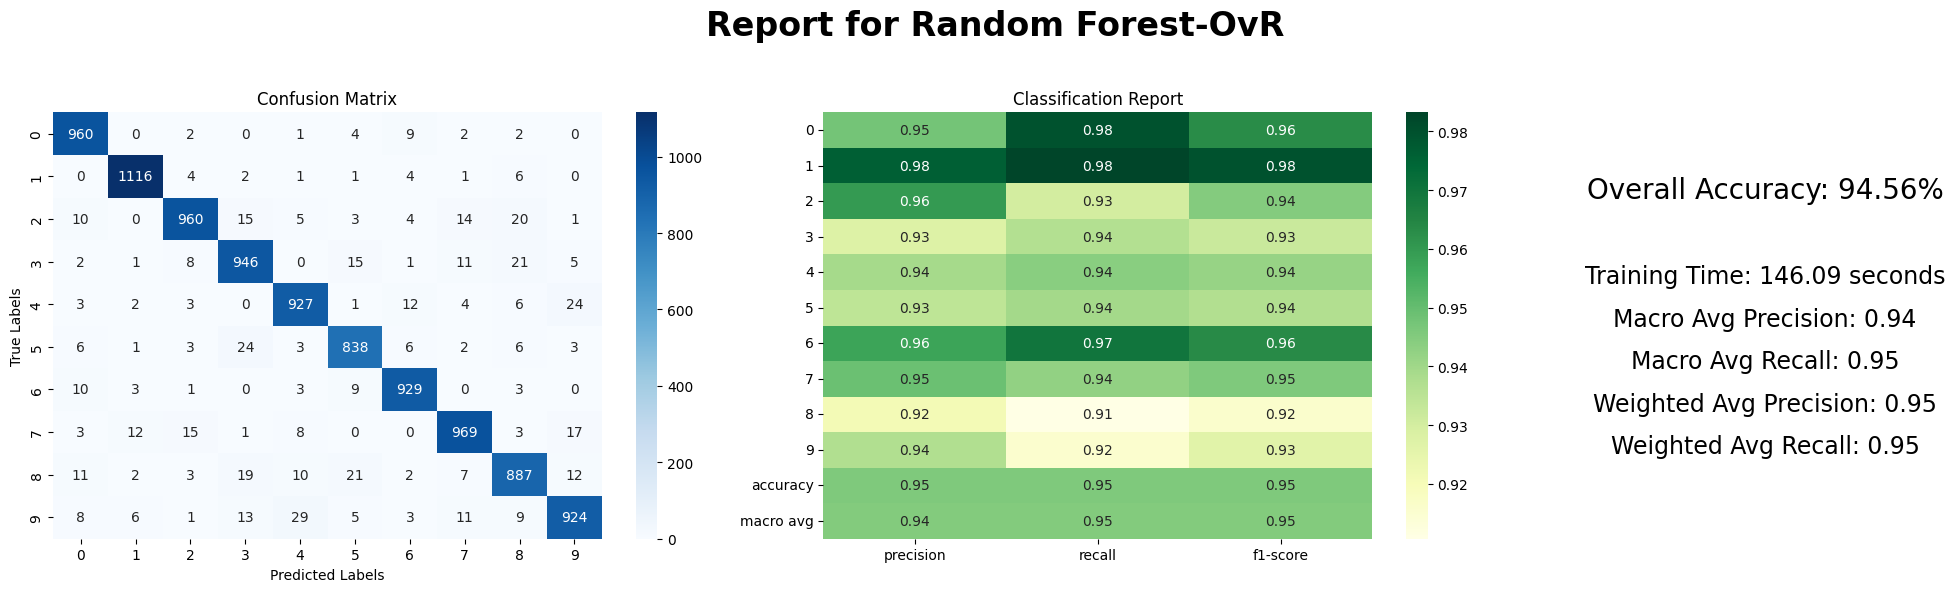

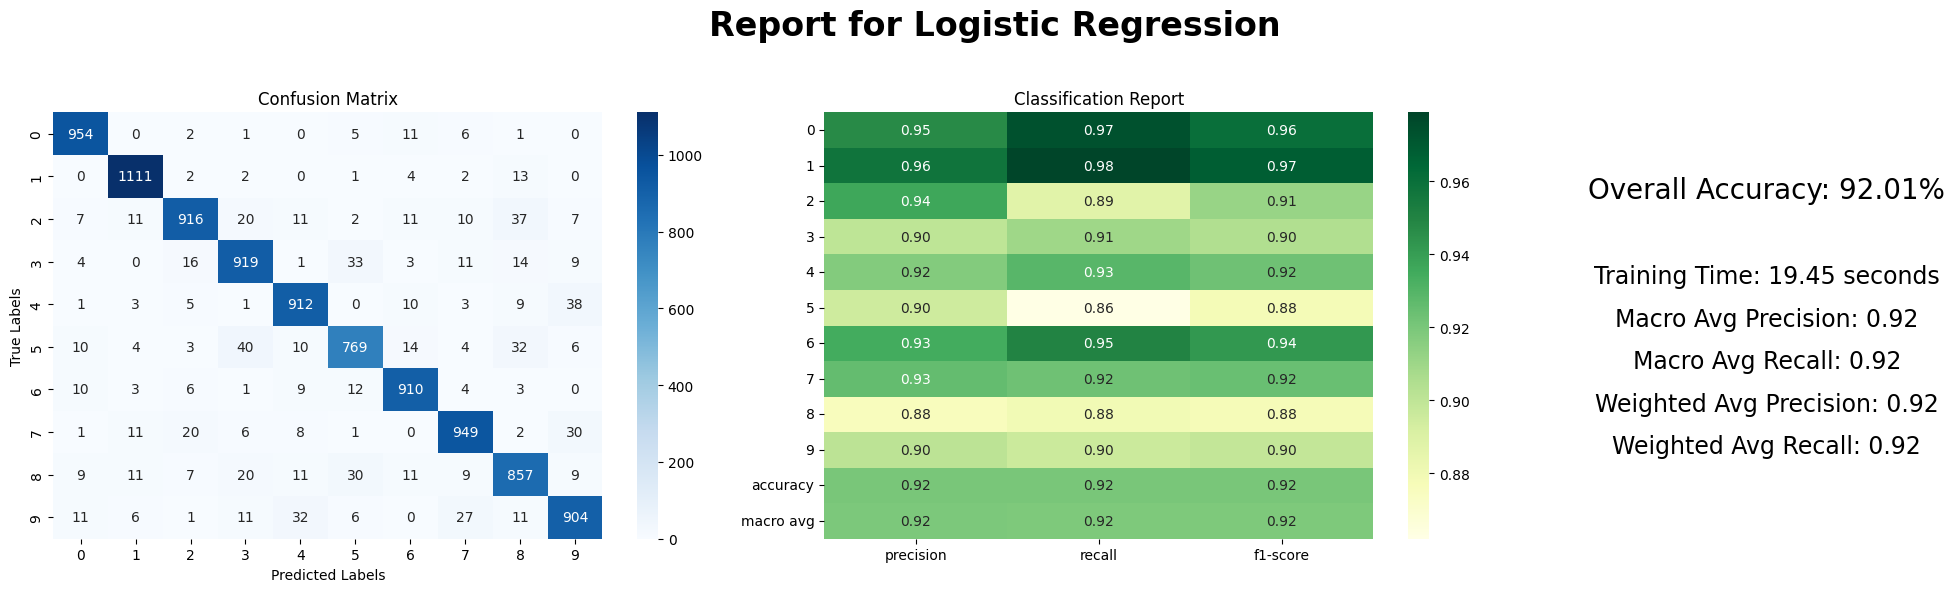

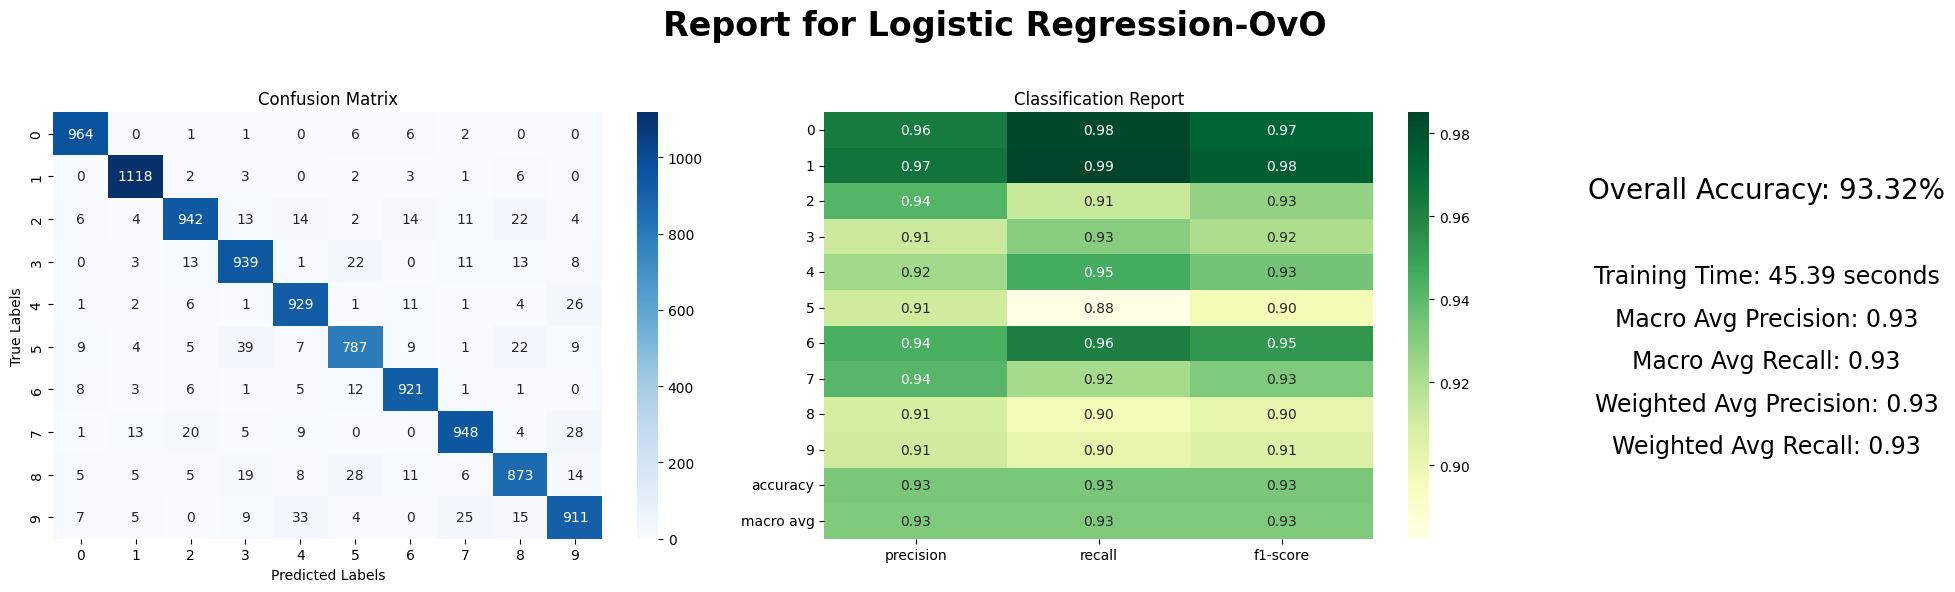

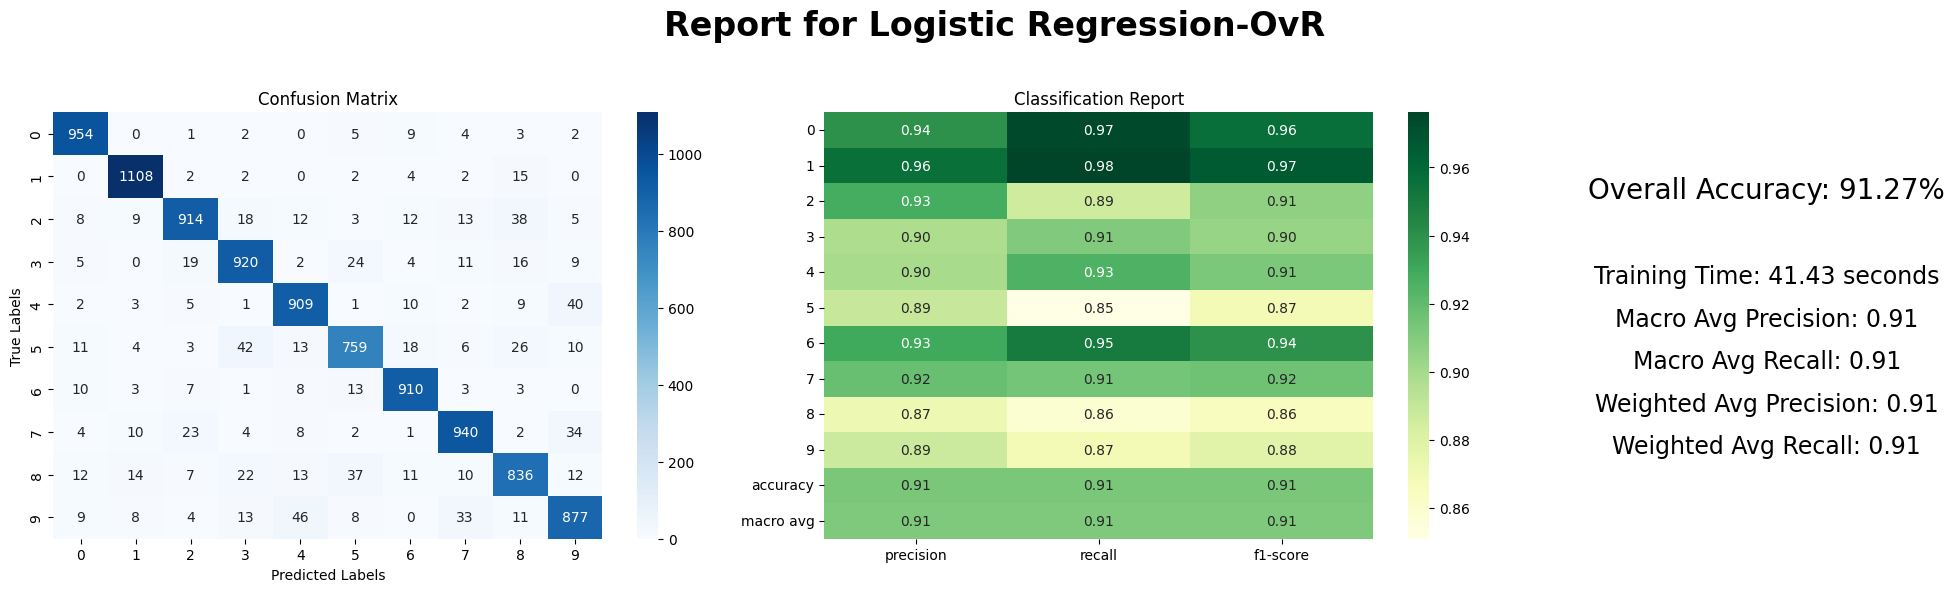

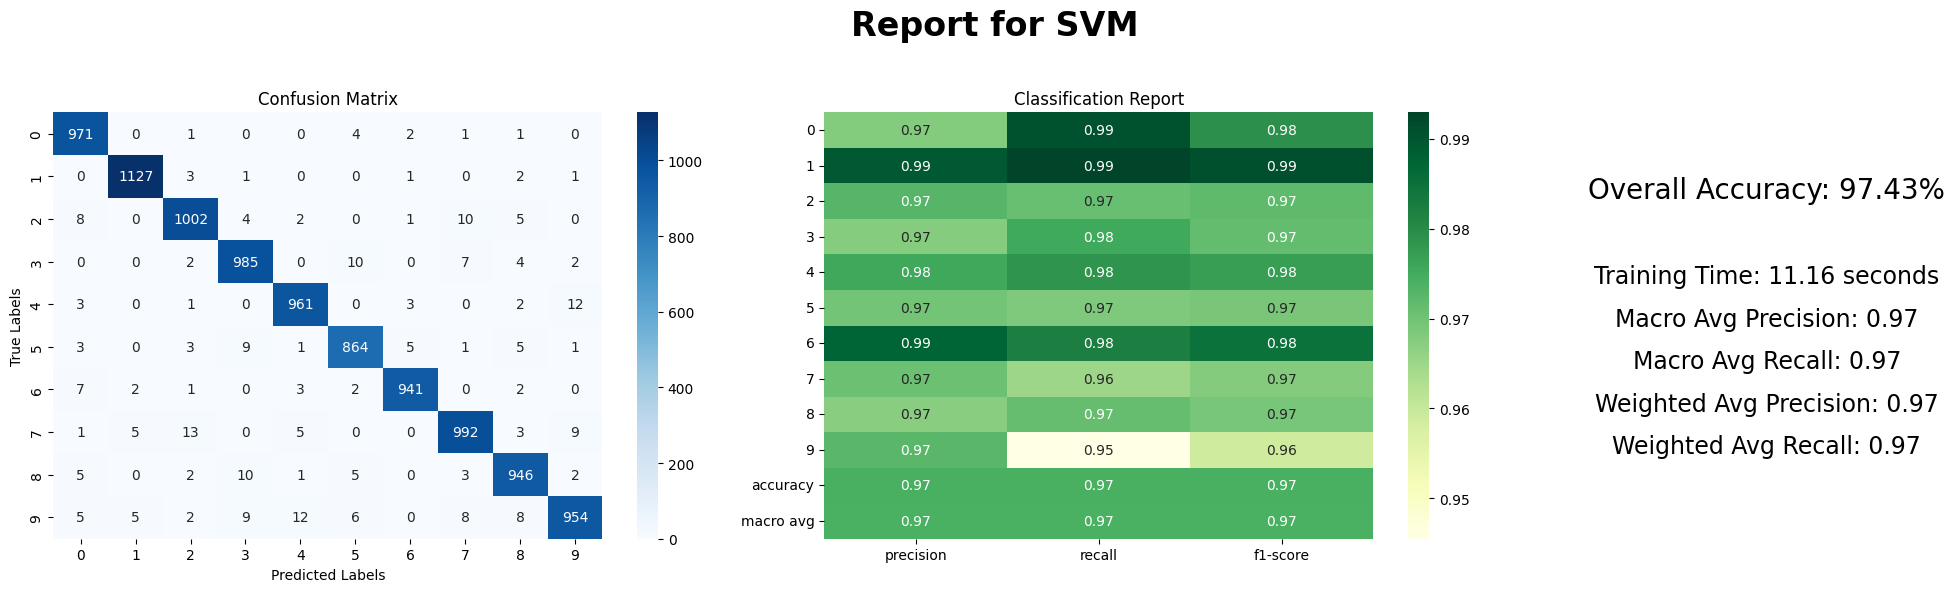

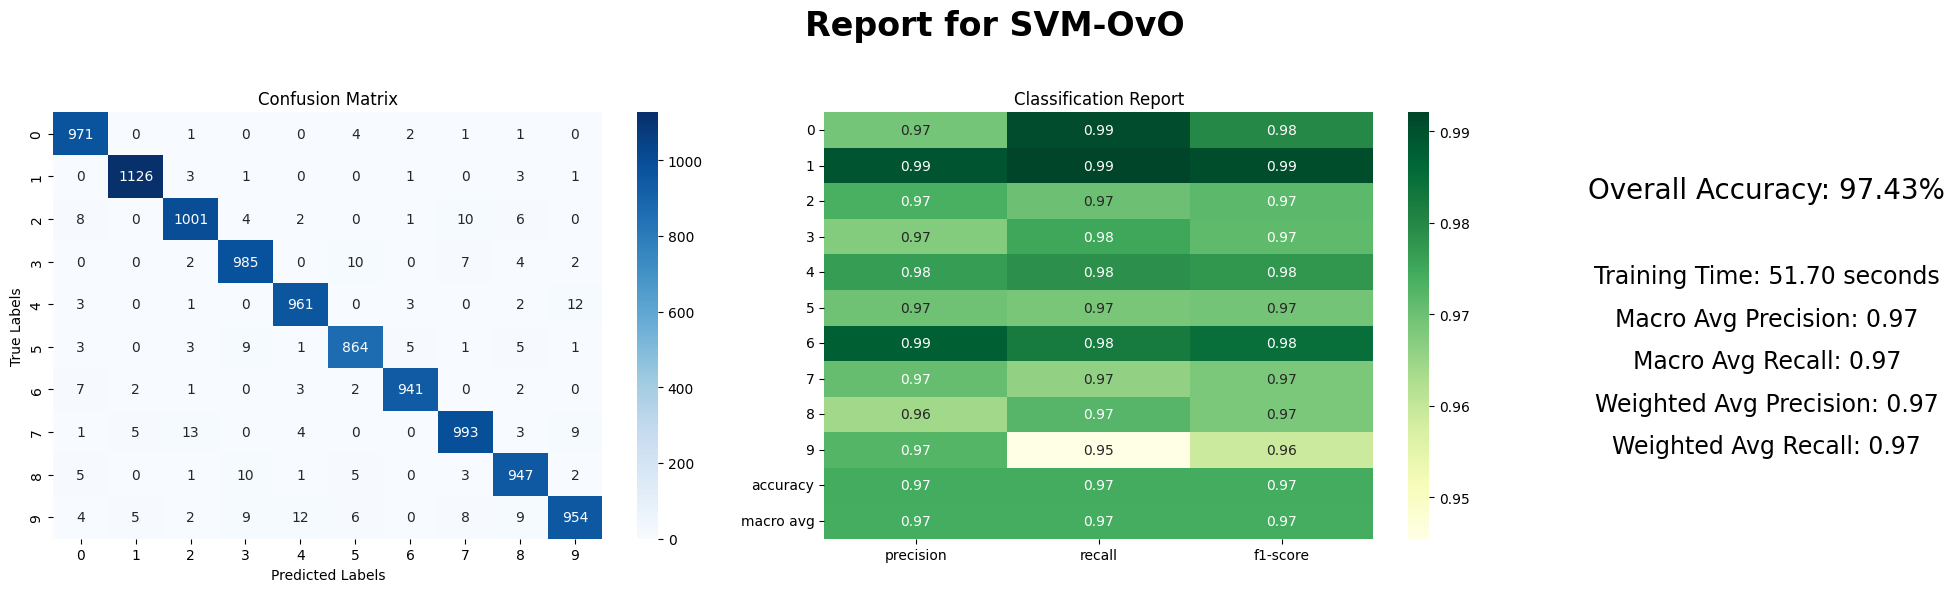

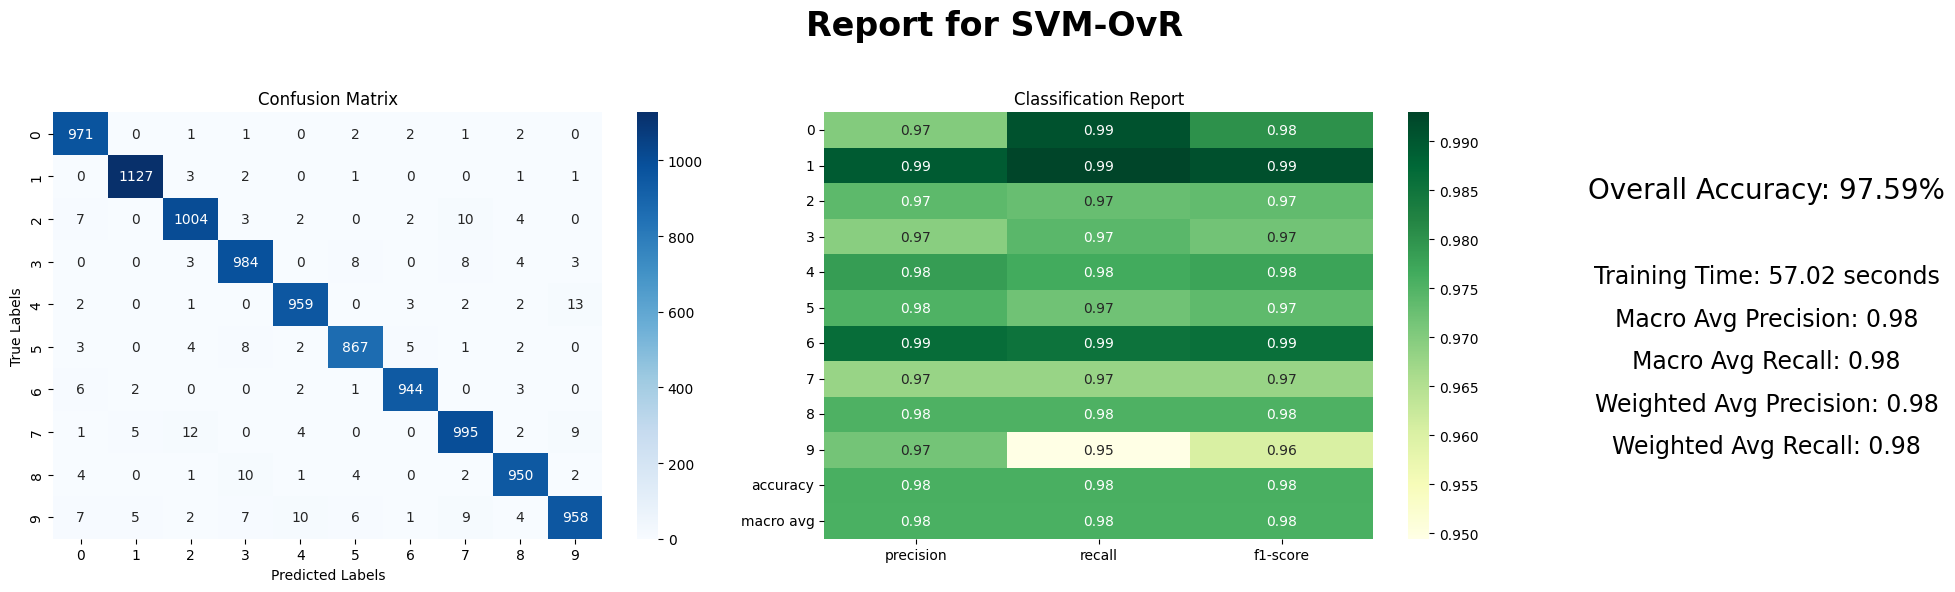

In [74]:
for model_name in models.keys():
    model = models[model_name]['model']
    model.set_params(**overall_best_params[model_name])
    report(model_name, model, X_train_scaled, y_train, X_test_scaled, y_test, overall_best_components[model_name])

## Ensemble learning - Bagging

In [82]:
def report_ensemble(model_name, model, X_train_scaled, y_train, X_test, y_test, components):
    X_train_pca, X_test_pca, reconstruction_loss = apply_pca(X_train_scaled, X_test_scaled, components)
    start = time.time()
    model.fit(X_train_pca, y_train)
    plot_classification_report_and_confusion_matrix(y_test, model.predict(X_test_pca), f"Report for {model_name}", time.time() - start)


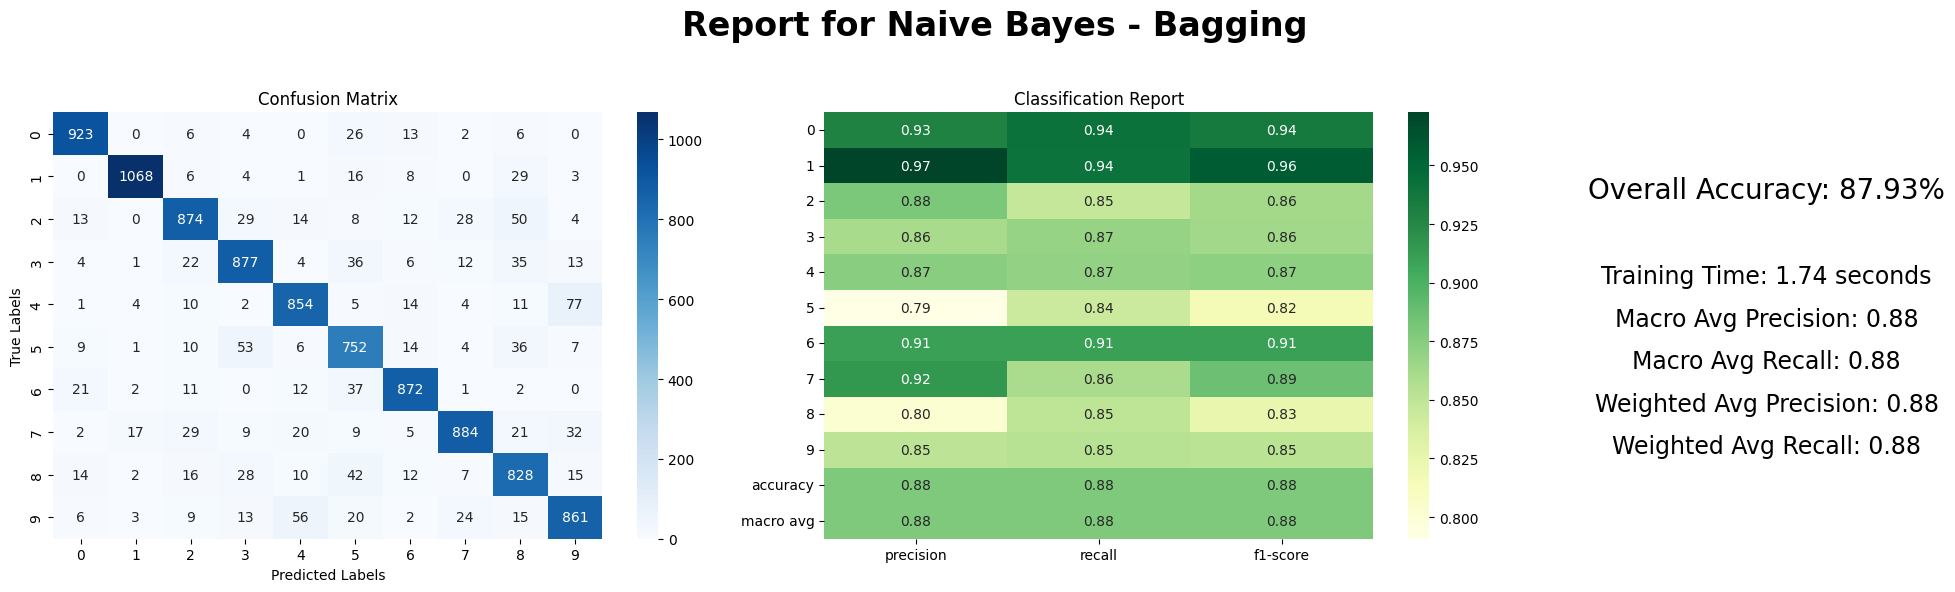

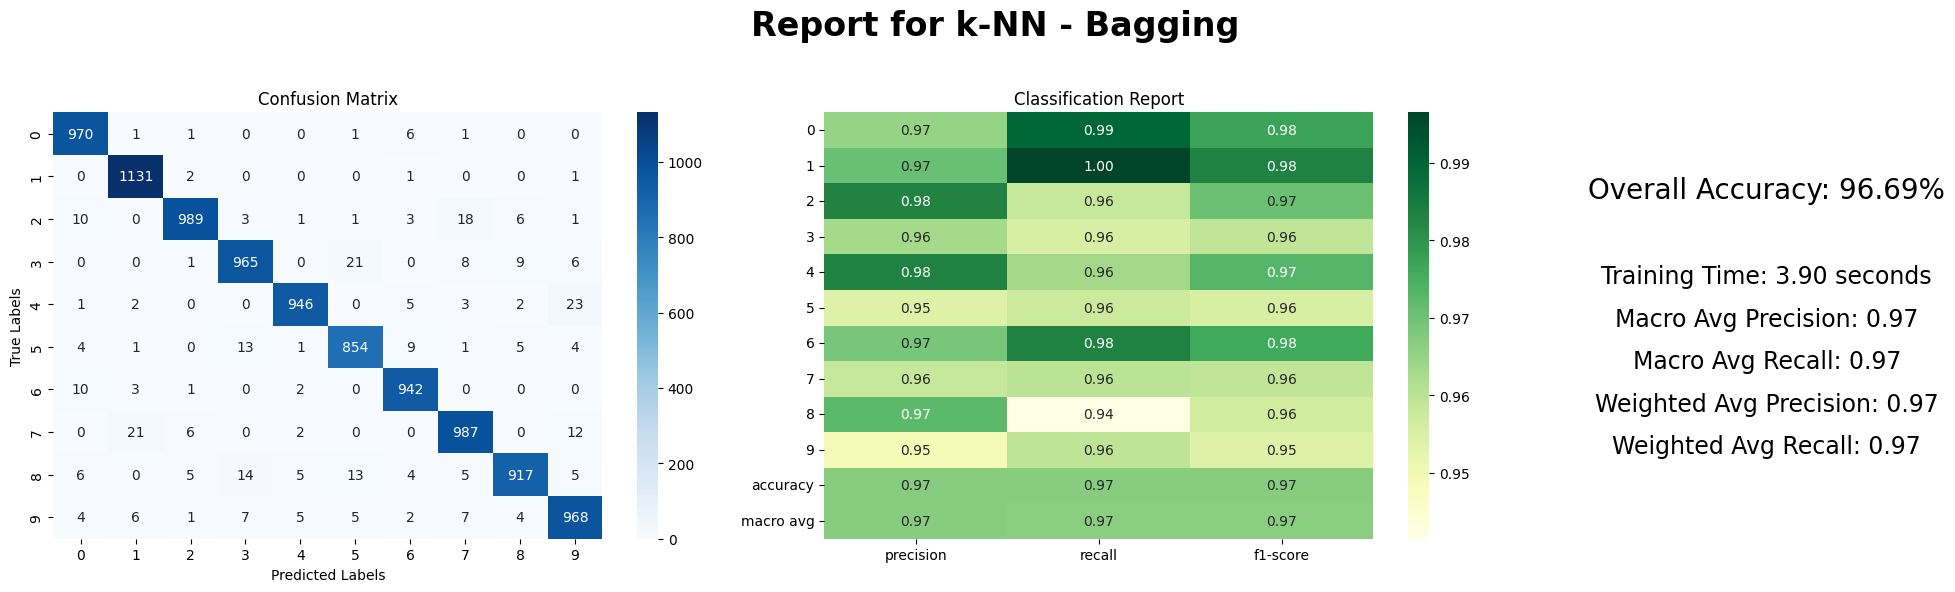

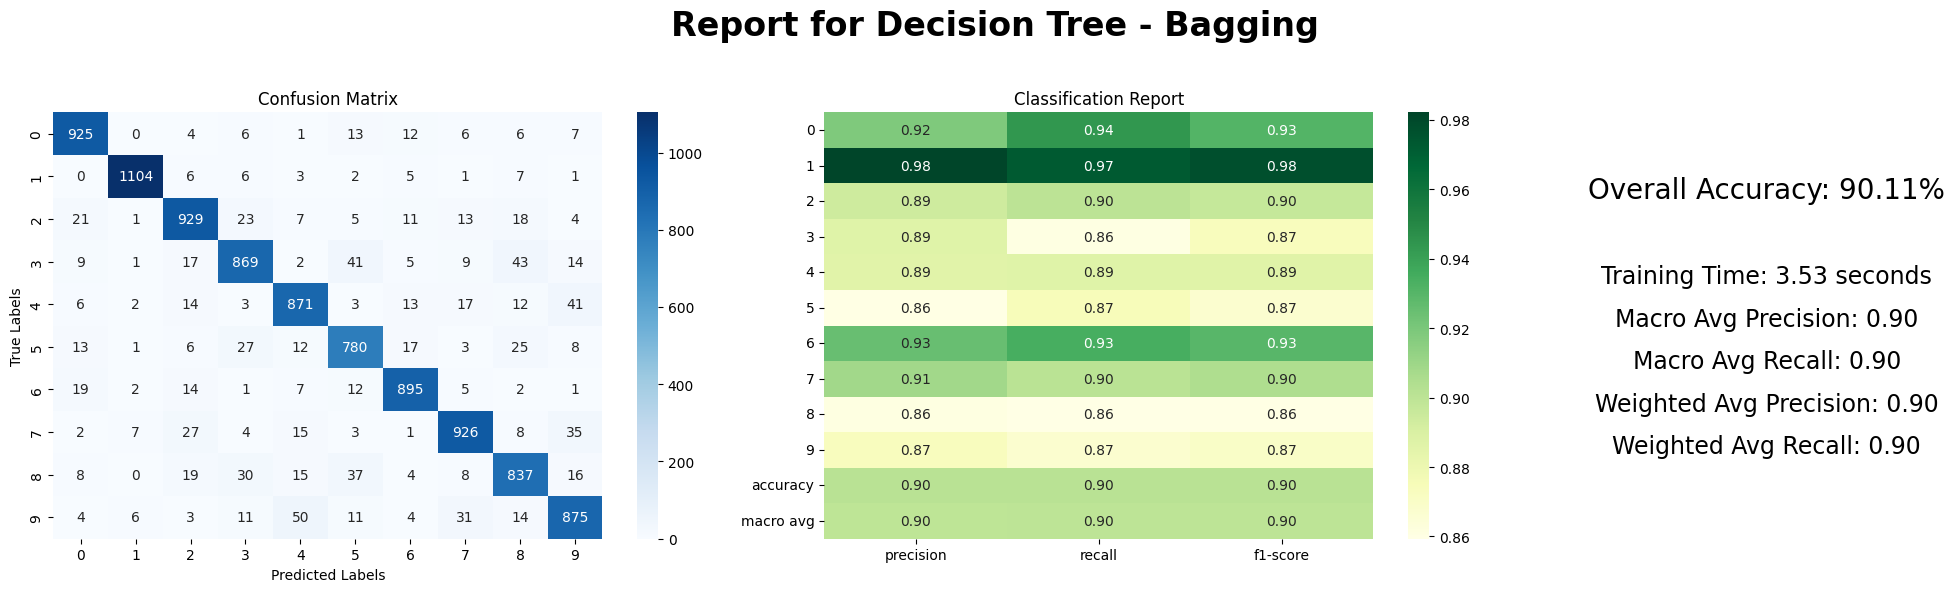

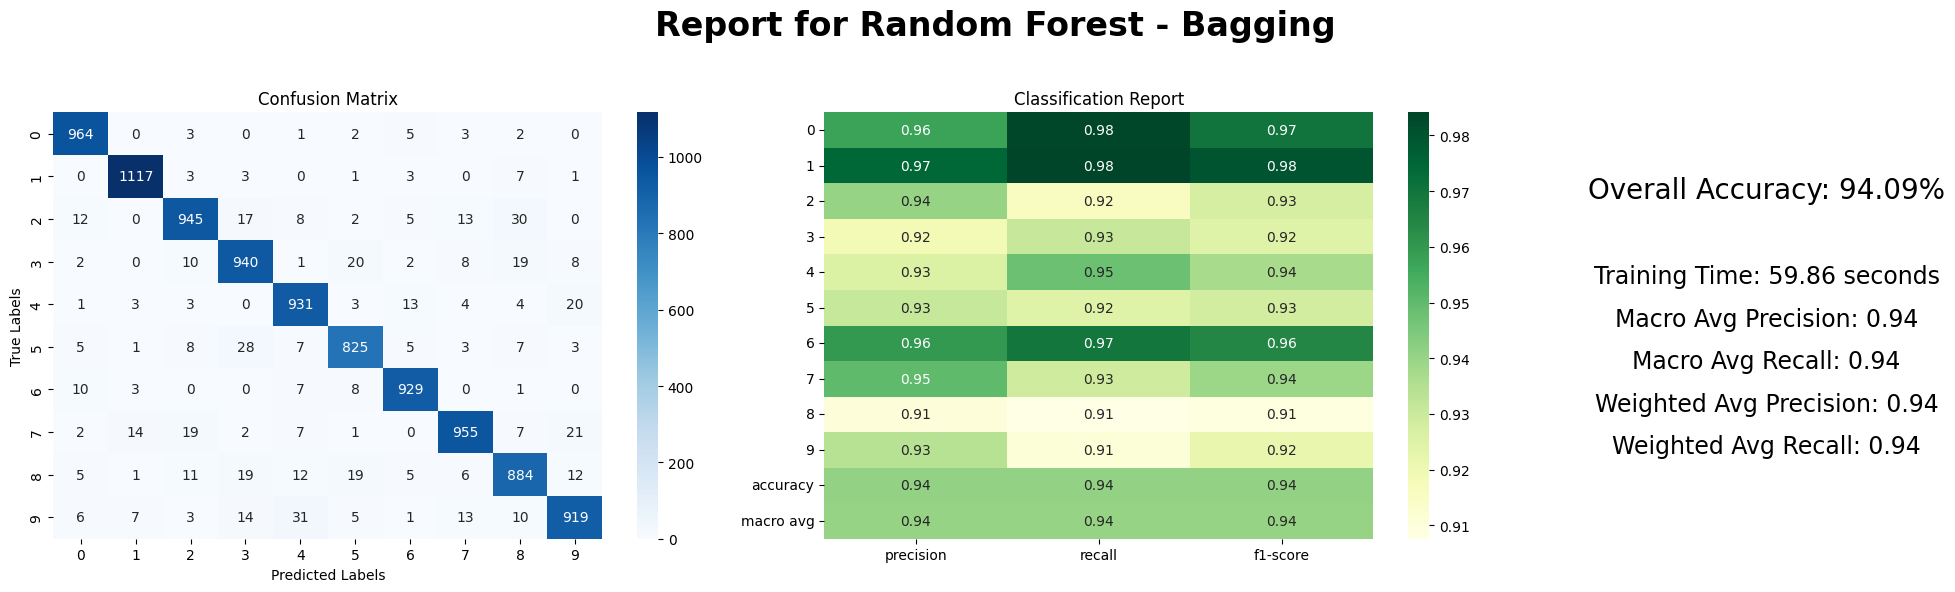

/home/bhavani/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bhavani/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bhavani/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bhavani/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


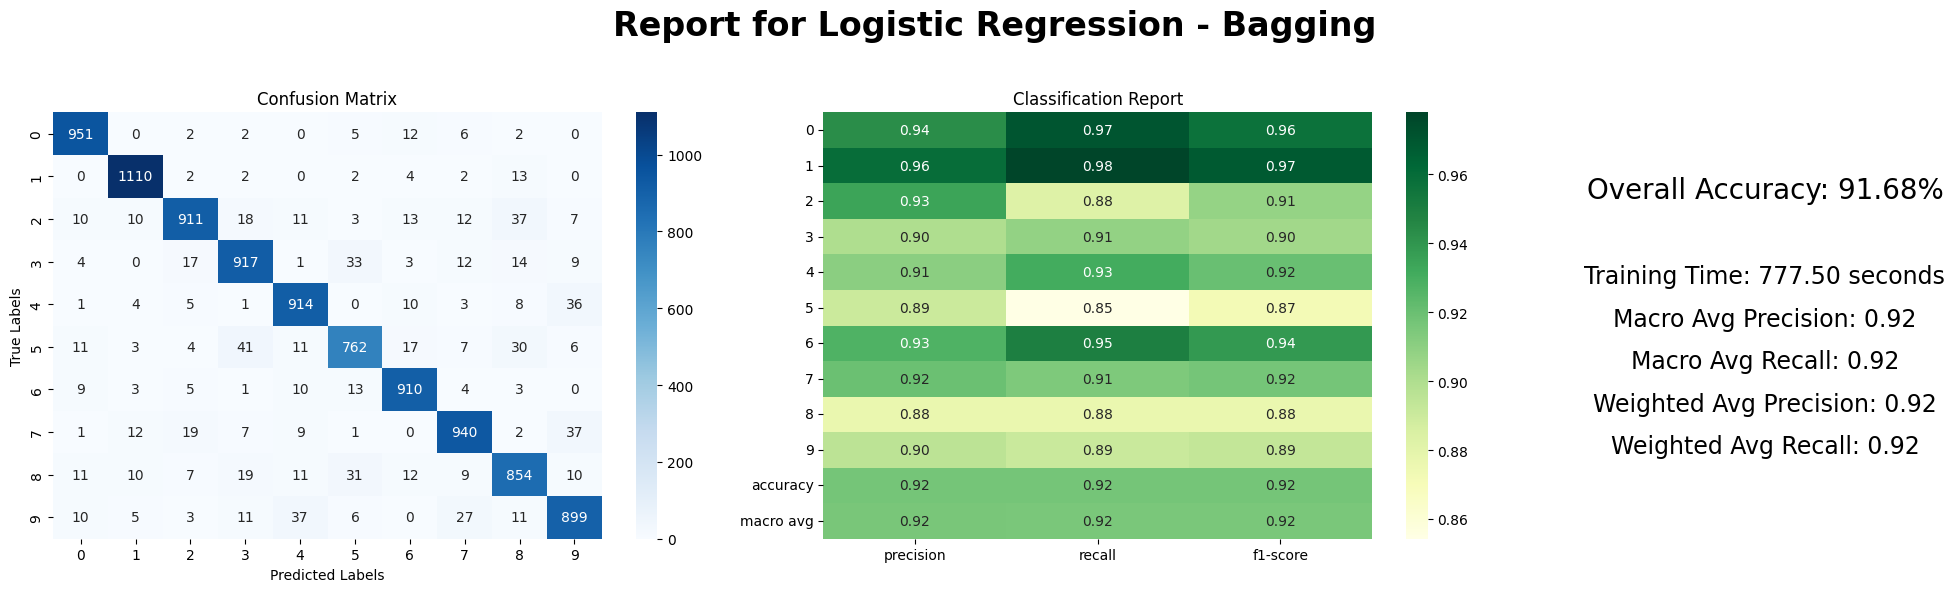

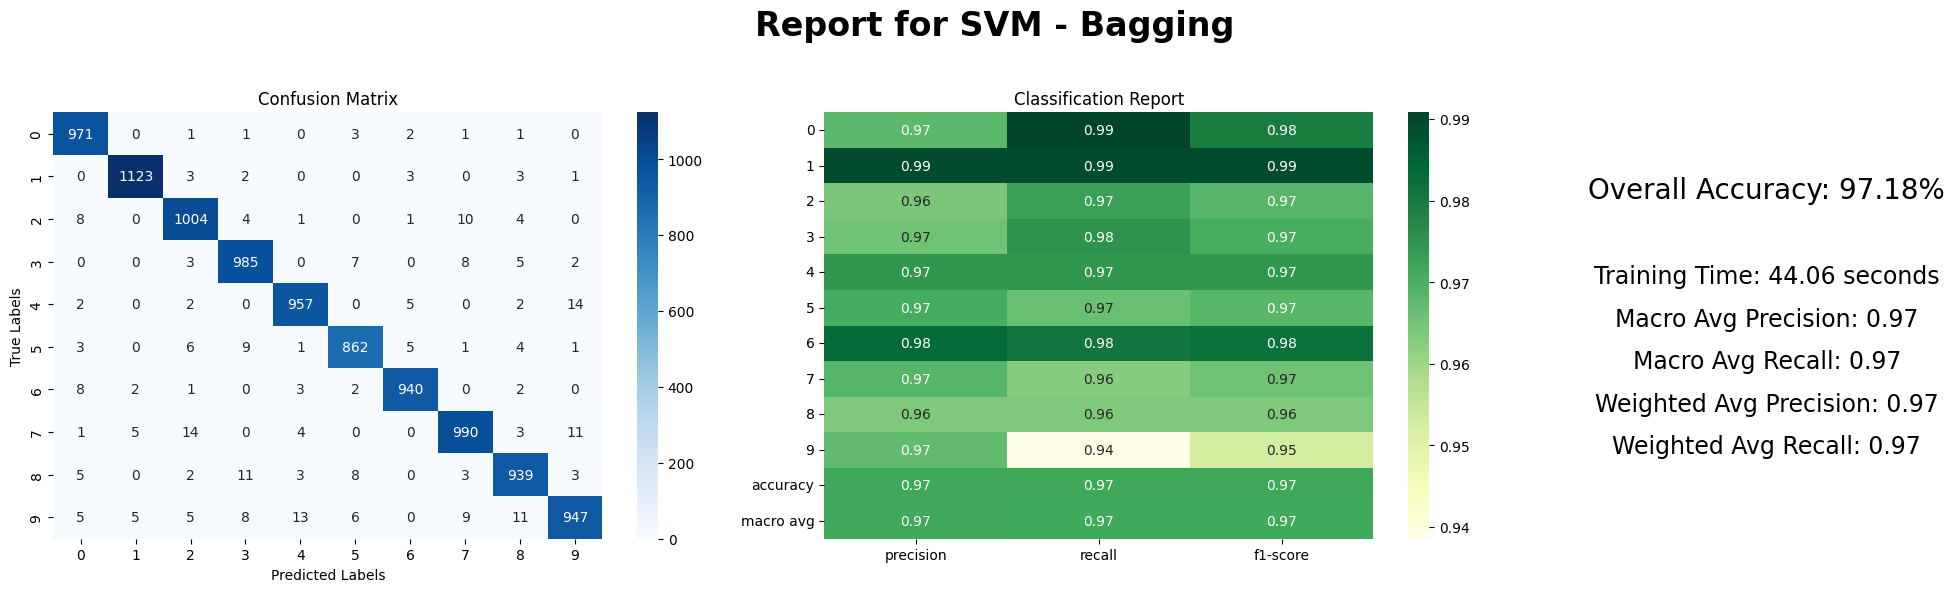

In [86]:
for model_name in models.keys():
    base_model = models[model_name]['model']
    base_model.set_params(**overall_best_params[model_name])
    bagging_model = BaggingClassifier(estimator=base_model,
                                      n_estimators=20,     
                                      max_samples=0.8,     
                                      max_features=1.0, 
                                      n_jobs=-1,
                                      random_state=42)
    report_ensemble(model_name + " - Bagging", bagging_model, X_train_scaled, y_train, X_test_scaled, y_test, overall_best_components[model_name])

    

## Ensemble learning - Boosting(AdaBoost)

### Doing Boosting only for Naive Bayes and Decision Trees as rest all have met their required accuracies

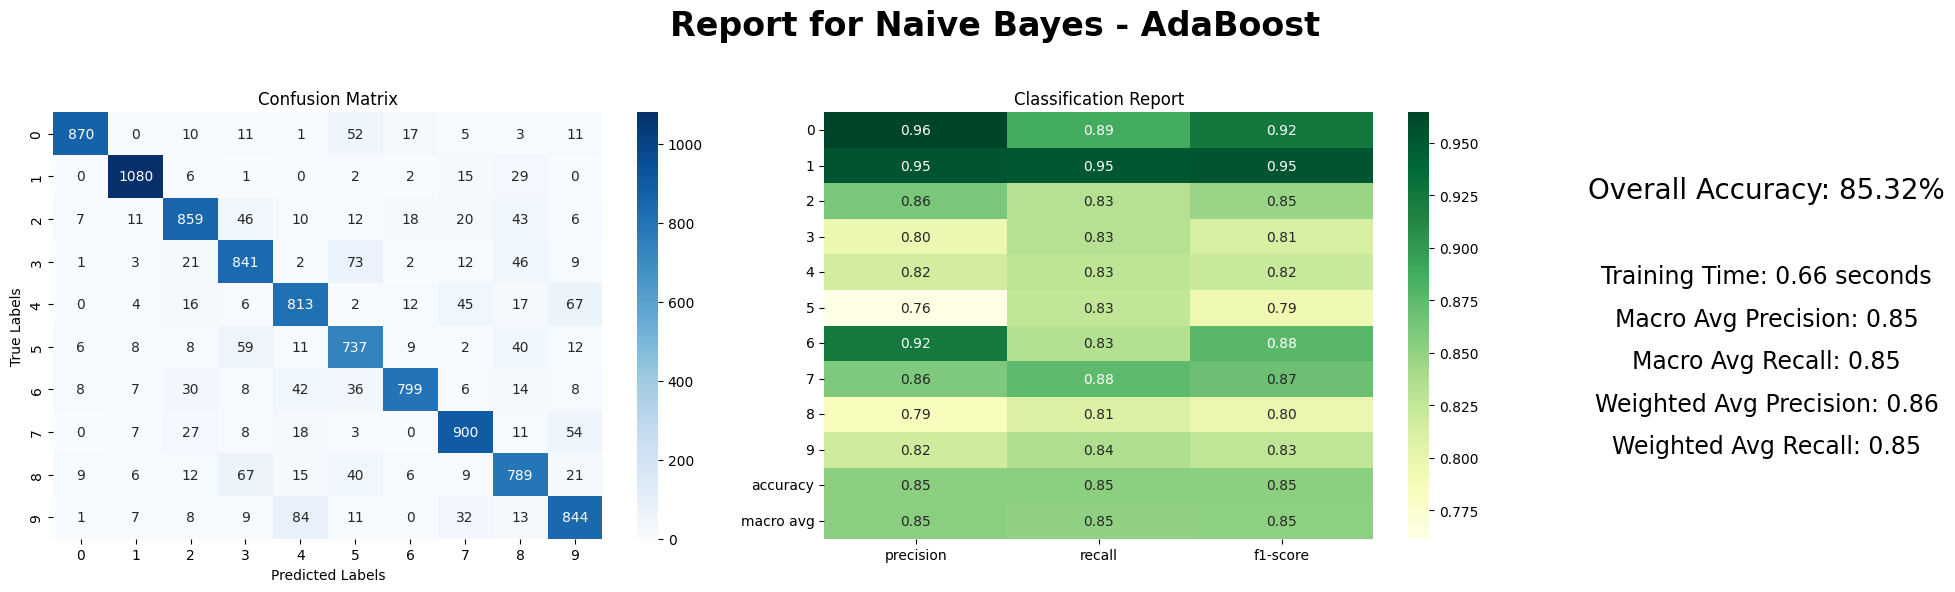

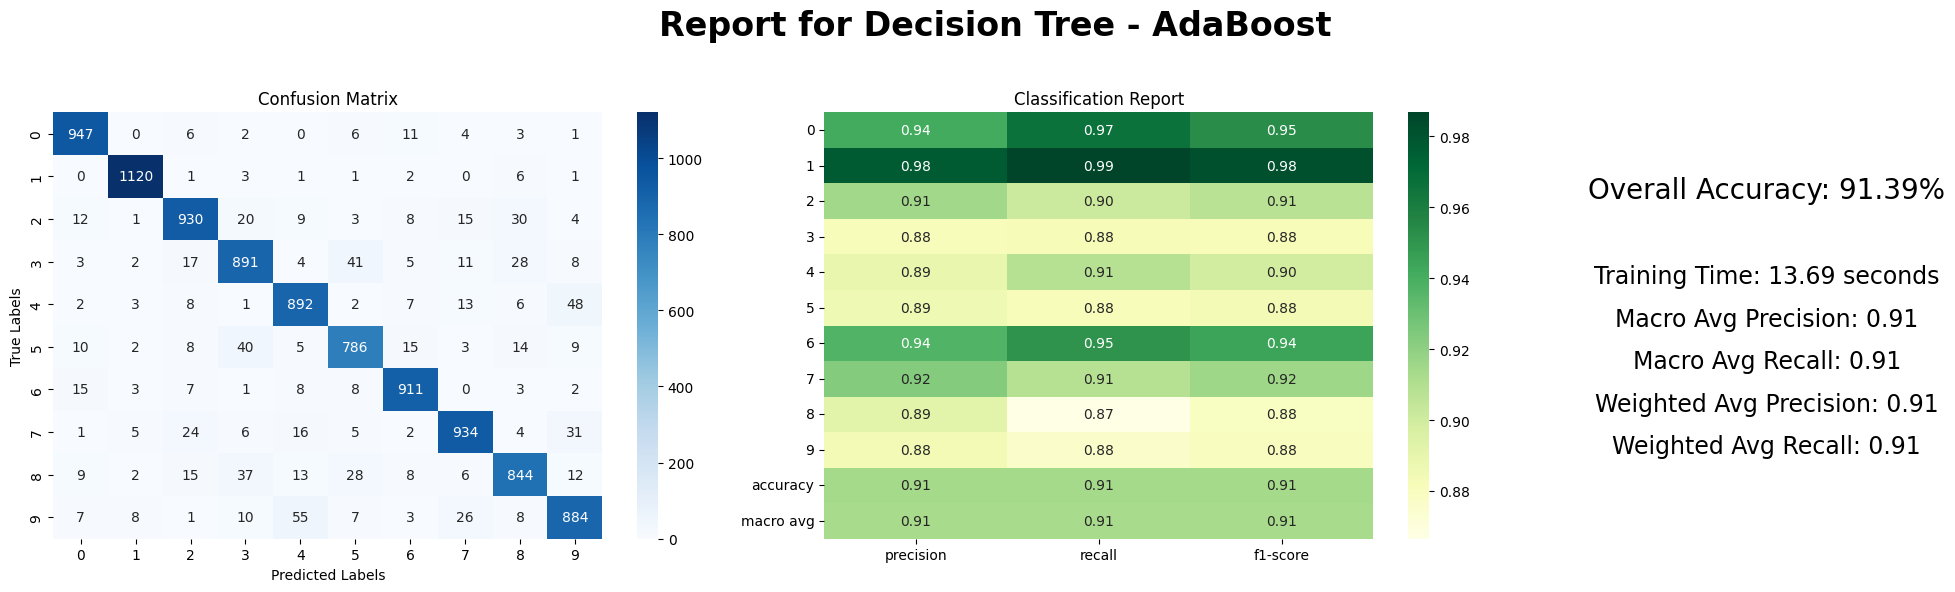

In [95]:
rest_models = ["Naive Bayes", "Decision Tree"]
for model_name in rest_models:
    base_model = models[model_name]['model']

    base_model.set_params(**overall_best_params[model_name])
    
    adaboost_model = AdaBoostClassifier(
        estimator=base_model,
        n_estimators=10,  
        learning_rate=1.0,
        random_state=42,
        algorithm='SAMME'
    )
    
    report_ensemble(model_name + " - AdaBoost", adaboost_model, X_train_scaled, y_train, X_test_scaled, y_test, overall_best_components[model_name])
